In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf

from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber, LogCosh

2025-05-01 20:11:08.155584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746123068.254286  187946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746123068.282498  187946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746123068.562274  187946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746123068.562345  187946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746123068.562347  187946 computation_placer.cc:177] computation placer alr

In [ ]:
def load_dataset(up_to= None):
    """
    Charge et combine les fichiers DVF annuels jusqu'à une année spécifiée (incluse).

    Paramètres :
        up_to : str, optionnel
            Année maximale à charger, parmi {"2019", ..., "2024"}.
            Si None, toutes les années disponibles sont chargées.

    Retour:
        pd.DataFrame
            Jeu de données concaténé sous forme de DataFrame Pandas.
            Retourne -1 en cas d'erreur sur l'année demandée.
    """

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

def parse_dataset(dataset, price= [-1, -1], all_local_types= True, surface_bati= [-1, -1], surface_terrain= -1, n_pieces= -1):
    """
    Nettoie et filtre les données DVF pour ne conserver que les ventes pertinentes à l'étude.

    Paramètres :
        dataset : pd.DataFrame
            Jeu de données DVF brut chargé avec `load_dataset`.

        price : list of float, optionnel
            Intervalle [min, max] pour filtrer les valeurs foncières.

        all_local_types : bool, optionnel
            Si False, ne conserve que les biens de type "Maison" ou "Appartement".

        surface_bati : list of float, optionnel
            Intervalle [min, max] pour la surface bâtie en m².

        surface_terrain : float, optionnel
            Surface maximale du terrain en m².

        n_pieces : int, optionnel
            Nombre maximal de pièces principales.

    Retour :
        dataset : pd.DataFrame
            Jeu de données nettoyé et filtré.

        features : list of str
            Liste des noms de colonnes sélectionnées comme variables explicatives.

        target : str
            Nom de la colonne cible : "Valeur fonciere".
    """

    dataset = dataset[(dataset["Nature mutation"] == "Vente")]

    dataset = dataset.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain", "Code postal"])
    dataset["Valeur fonciere"] = dataset["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
    dataset["Date mutation"] = pd.to_datetime(dataset["Date mutation"], format= "%d/%m/%Y", errors= "coerce")
    # dataset["Annee"] = dataset["Date mutation"].dt.year
    dataset["Mois"] = dataset["Date mutation"].dt.month
    # dataset["Jour"] = dataset["Date mutation"].dt.day
    dataset["Surface reelle bati"] = dataset["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    dataset["Nombre pieces principales"] = dataset["Nombre pieces principales"].astype(int)
    dataset["Surface terrain"] = dataset["Surface terrain"].str.replace(",", ".", regex= False).astype(float)
    dataset["Code postal"] = dataset["Code postal"].astype(str)

    dataset["Prix au m2"] = dataset["Valeur fonciere"] / dataset["Surface reelle bati"]
    # dataset["Ratio surface terrain bati"] = dataset["Surface terrain"] / dataset["Surface reelle bati"]
    # dataset["Ratio pieces surface bati"] = dataset["Nombre pieces principales"] / dataset["Surface reelle bati"]

    freq_cp = dataset["Code postal"].value_counts()
    dataset["Frequence CP"] = dataset["Code postal"].map(freq_cp)

    if all_local_types is not True:
        dataset = dataset[(dataset["Type local"] == "Maison") | (dataset["Type local"] == "Appartement")]
    if price[0] >= 0:
        dataset = dataset[dataset["Valeur fonciere"] >= price[0]]
    if (price[1] > 0) & (price[0] < price[1]):
        dataset = dataset[dataset["Valeur fonciere"] <= price[1]]
    if surface_bati[0] > 0:
        dataset = dataset[dataset["Surface reelle bati"] >= surface_bati[0]]
    if (surface_bati[1] > 0) & (surface_bati[0] < surface_bati[1]):
        dataset = dataset[dataset["Surface reelle bati"] <= surface_bati[1]]
    if surface_terrain >= 0:
        dataset = dataset[dataset["Surface terrain"] <= surface_terrain]
    if n_pieces > 1:
        dataset = dataset[(dataset["Nombre pieces principales"] >= 1) & (dataset["Nombre pieces principales"] <= n_pieces)]
    # (dataset["Prix au m2"] >= 300) &
    # (dataset["Prix au m2"] <= 10_000)

    features = ["Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    target = "Valeur fonciere"

    return dataset, features, target

def visualize_dataset(dataset, price= [-1, -1], all_local_types= True, surface_bati= [-1, -1], surface_terrain= -1, n_pieces= -1):
    """
    Visualise et explore les caractéristiques statistiques et graphiques du jeu de données DVF filtré.

    Cette fonction permet :
    - de filtrer les données selon plusieurs critères (type, surface, prix, etc.)
    - d'afficher des résumés statistiques et des distributions pour les colonnes principales
    - de visualiser l'évolution temporelle des ventes, les distributions des prix et la corrélation entre variables

    Paramètres :
        dataset : pd.DataFrame
            Jeu de données brut contenant les ventes immobilières (format DVF).

        price : list [float, float], optionnel
            Intervalle de prix à conserver (en €). Si non précisé, tous les prix sont conservés.

        all_local_types : bool, optionnel
            Si False, ne conserve que les biens de type "Maison" ou "Appartement".

        surface_bati : list [float, float], optionnel
            Intervalle de surface bâtie à conserver (en m²).

        surface_terrain : float, optionnel
            Surface maximale de terrain autorisée (en m²).

        n_pieces : int, optionnel
            Nombre maximum de pièces principales.

    Retour :
        None
    """

    dataset, features, _ = parse_dataset(dataset, price, all_local_types, surface_bati, surface_terrain, n_pieces)
    X = dataset[features]
    print("Shape des features:", X.shape)
    print("Colonnes:", X.columns.tolist())
    print("\nAperçu des données:")
    display(X.head())
    print("\nRésumé statistique des variables numériques:")
    display(X.describe())
    print("\nRépartition des types de biens:")
    print(X["Type local"].value_counts())

    plt.figure(figsize= (20, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Date mutation"], subset["Valeur fonciere"], label= type_local, alpha= .4, s= 1)
    plt.title("Ventes à différentes dates")
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.xlabel("Date de vente")
    plt.ylabel("Valeur foncière (€)")
    plt.yscale("log")
    plt.grid(True, which= "both")
    plt.tight_layout()
    plt.show()

    bins = int(X.shape[0] ** (1/3))
    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
       subset = dataset[dataset["Type local"] == type_local]
       plt.hist(subset["Valeur fonciere"], label= type_local, alpha= .4, bins= bins , log= False, density= False)
    plt.hist(dataset["Valeur fonciere"], label= "Total", bins= bins, log= False, density= False, histtype= "step", color = 'k')
    plt.title("Distribution des valeurs foncière")
    plt.xlabel("Valeur foncière (€)")
    plt.ylabel("Nombre de ventes")
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.show()

    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Surface reelle bati"], subset["Valeur fonciere"], label= type_local, alpha= .4, s= 1)
    plt.title("Valeur foncière en fonction de la surface du bâtiement")
    plt.xlabel("Surface réelle (m²)")
    plt.ylabel("Valeur foncière (€)")
    plt.grid(True)
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (20, 6))
    plt.scatter(dataset["Code departement"], dataset["Prix au m2"], s= 1)
    for departement in dataset["Code departement"].unique():
        subset = dataset[dataset["Code departement"] == departement]
        plt.errorbar(departement, np.mean(subset["Prix au m2"]), yerr= np.std(subset["Prix au m2"], ddof= 1), c= "k", capsize= 6)
    plt.title("Distribution du prix au m² par département")
    plt.xlabel("Code département")
    plt.ylabel("Prix au m² (€)")
    plt.xticks(rotation= 45)
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (10, 6))
    seaborn.heatmap(dataset.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de corrélation des variables numériques")
    plt.tight_layout()
    plt.show()

    return

def process_features(X):
    """
    Prépare les variables explicatives en appliquant une transformation adaptée à chaque type de feature.

    Paramètres :
    X : pd.DataFrame
        DataFrame contenant les variables explicatives brutes.

    Retour :
    X_processed : scipy.sparse matrix
        Matrice transformée contenant :
        - les variables numériques standardisées (via StandardScaler),
        - les variables catégorielles encodées en one-hot (via OneHotEncoder).
    """

    categorical_features = ["Code departement", "Type local"]
    numeric_features = ["Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    preprocessor = ColumnTransformer(transformers= [(
        'num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)
        ])
    X_processed = preprocessor.fit_transform(X)

    return X_processed

In [ ]:
def handle_dataset(dataset, features, target, sampled= True, sample_size= 1e5, log= True):
    """
    Prépare les données pour l'entraînement, la validation et le test d'un modèle.

    Cette fonction effectue :
    - Un échantillonnage optionnel du dataset.
    - Un pré-traitement des features (encodage et normalisation).
    - Une transformation logarithmique optionnelle de la target.
    - Une séparation en ensembles d'entraînement, validation et test.

    Paramètres :
        dataset : pd.DataFrame
            Données DVF filtrées contenant les features et la target.

        features : list of str
            Noms des colonnes à utiliser comme variables explicatives.

        target : str
            Nom de la colonne cible (valeur foncière).

        sampled : bool, optionnel
            Si True, un échantillon de `sample_size` lignes est prélevé aléatoirement.

        sample_size : int, optionnel
            Nombre de lignes à prélever si `sampled=True`.

        log : bool, optionnel
            Si True, applique une transformation logarithmique sur la target.

    Retour :
        tuple of arrays
            (X_train, X_vali, X_test, y_train, y_vali, y_test) prêts à l'emploi pour les modèles.
    """

    X, y = dataset[features], dataset[target]

    if sampled is True:
        X_sampled = X.sample(n= int(sample_size))
        y_sampled = y.loc[X_sampled.index]
        X_processed = process_features(X_sampled)
        y = y_sampled
    else:
        X_processed = process_features(X)

    if log is True:
        y = np.log1p(y)

    X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size= .2)
    X_train, X_vali, y_train, y_vali = train_test_split(X_temp, y_temp, test_size= .2)

    return X_train, X_vali, X_test, y_train, y_vali, y_test

---

# 1. Chargement des données DVF

On charge les fichiers DVF (depuisle dossier "data/") de 2019 à 2021 (ou plus), et on les concatène dans un seul DataFrame.

Les données sont brutes : elles contiennent tous types de mutations (ventes, donations...) et un grand nombre de colonnes inutiles pour notre cas.

On rassemble une base cohérente et suffisamment large pour entraînement et validation.

In [4]:
data = load_dataset(up_to= "2021") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...
Chargement 2020...
Chargement 2021...

10,162,527 lignes chargées au total.


---

# 2. Visualisation exploratoire

Avant modéliser, on explore visuellement les données :

Cette étape comprend :
- Un nuage de points montrant la relation entre **surface bâtie** et **valeur foncière**.
- Un nuage de points montrant les **valeurs de vente** à différentes dates.
- Une visualisation du **prix au m² par département**.
- La **matrice de corrélation** entre les variables numériques.

Cela permet de :
- Détecter des **relations linéaires ou non linéaires** entre les variables.
- Identifier les **valeurs extrêmes** (outliers).
- Repérer des corrélations intéressantes ou redondantes.
- Guider les choix de **features à conserver**, de **normalisation**, ou de **transformations** à appliquer.

On determine les transformations, ou filtrages supplémentaires à réaliser.

## Visualisation des données non traités :

Shape des features: (3052044, 7)
Colonnes: ['Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Mois', 'Frequence CP']

Aperçu des données:


Code departement Type local  Surface terrain  Surface reelle bati  \
0               01     Maison            695.0                150.0   
1               01     Maison            888.0                 94.0   
2               01     Maison            500.0                 94.0   
3               01     Maison            522.0                 90.0   
5               01     Maison           2483.0                110.0   

   Nombre pieces principales  Mois  Frequence CP  
0                          5     7          1376  
1                          4     7           910  
2                          4     7           910  
3                          3     7           910  
5                          5     7           313


Résumé statistique des variables numériques:


Surface terrain  Surface reelle bati  Nombre pieces principales  \
count     3.052044e+06         3.052044e+06               3.052044e+06   
mean      1.357007e+03         1.101640e+02               2.853557e+00   
std       7.864717e+03         8.285017e+02               2.265819e+00   
min       0.000000e+00         0.000000e+00               0.000000e+00   
25%       2.700000e+02         2.500000e+01               0.000000e+00   
50%       5.230000e+02         7.800000e+01               3.000000e+00   
75%       1.000000e+03         1.100000e+02               4.000000e+00   
max       2.960000e+06         3.129620e+05               1.090000e+02   

               Mois  Frequence CP  
count  3.052044e+06  3.052044e+06  
mean   7.595448e+00  1.079304e+03  
std    3.269233e+00  1.112928e+03  
min    1.000000e+00  1.000000e+00  
25%    5.000000e+00  4.380000e+02  
50%    8.000000e+00  7.580000e+02  
75%    1.000000e+01  1.275000e+03  
max    1.200000e+01  9.054000e+03


Répartition des types de biens:
Type local
Maison                                      1830125
Dépendance                                   672759
Appartement                                  364699
Local industriel. commercial ou assimilé     184461
Name: count, dtype: int64


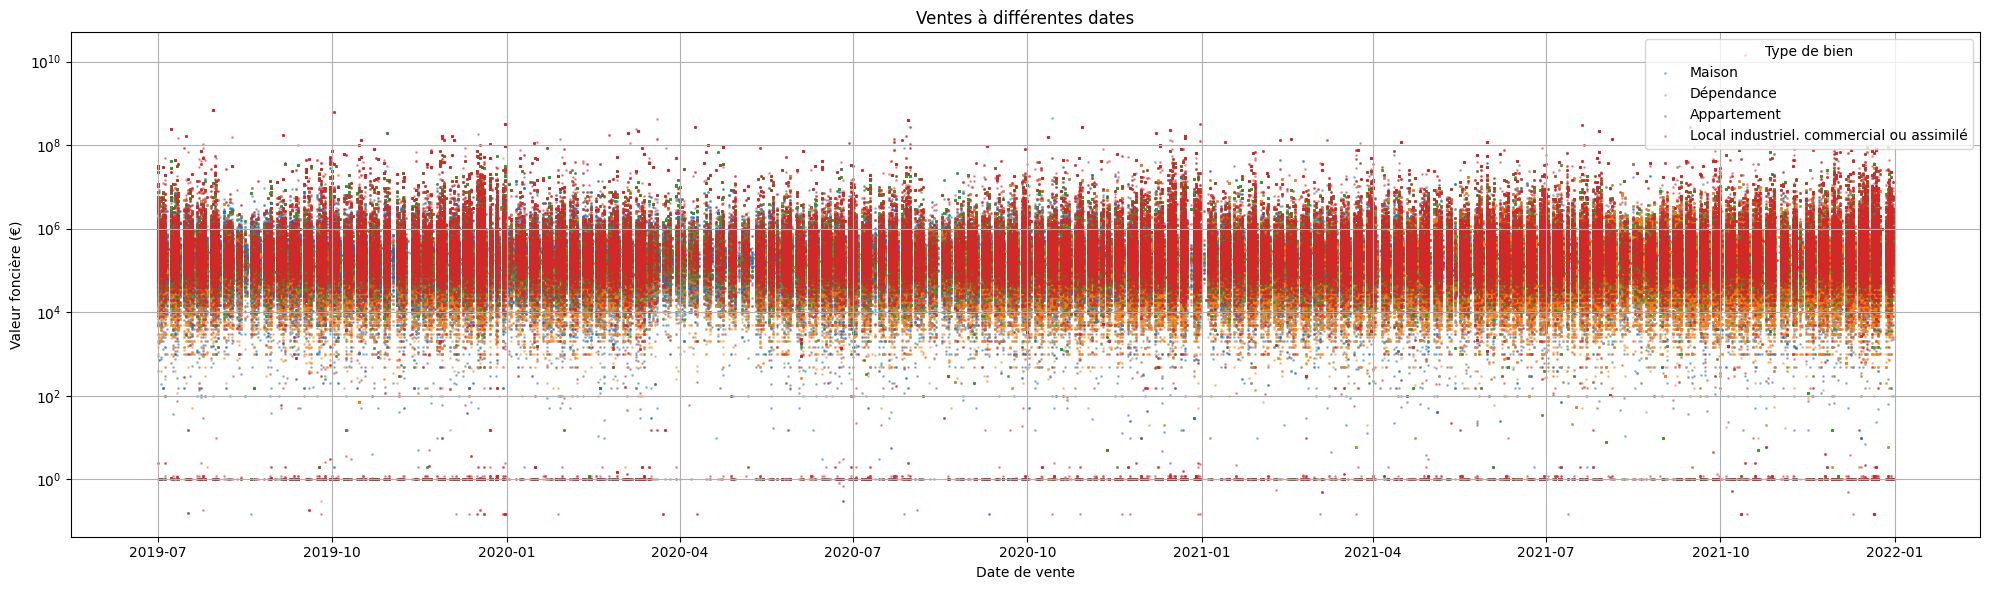

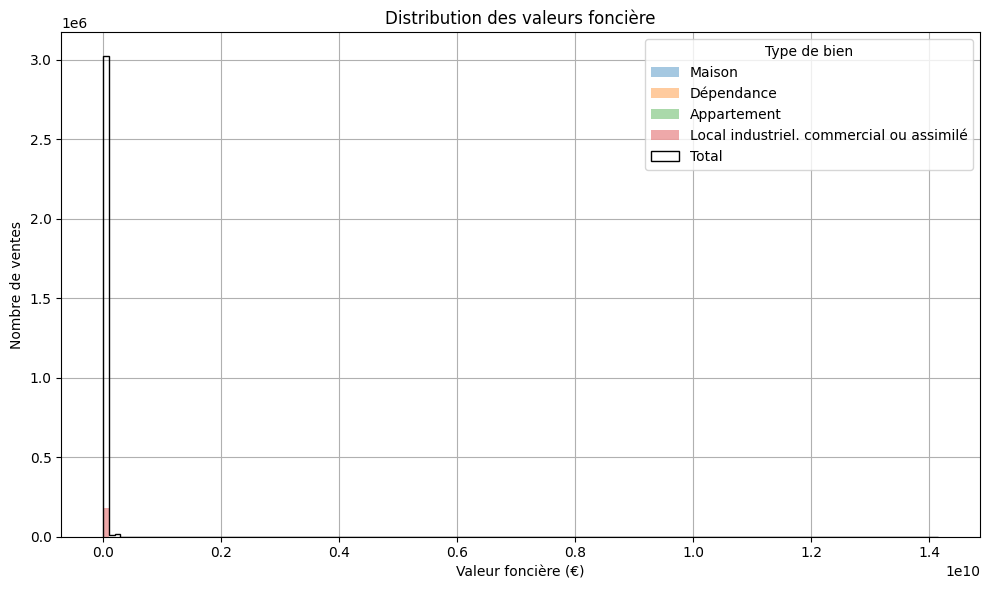

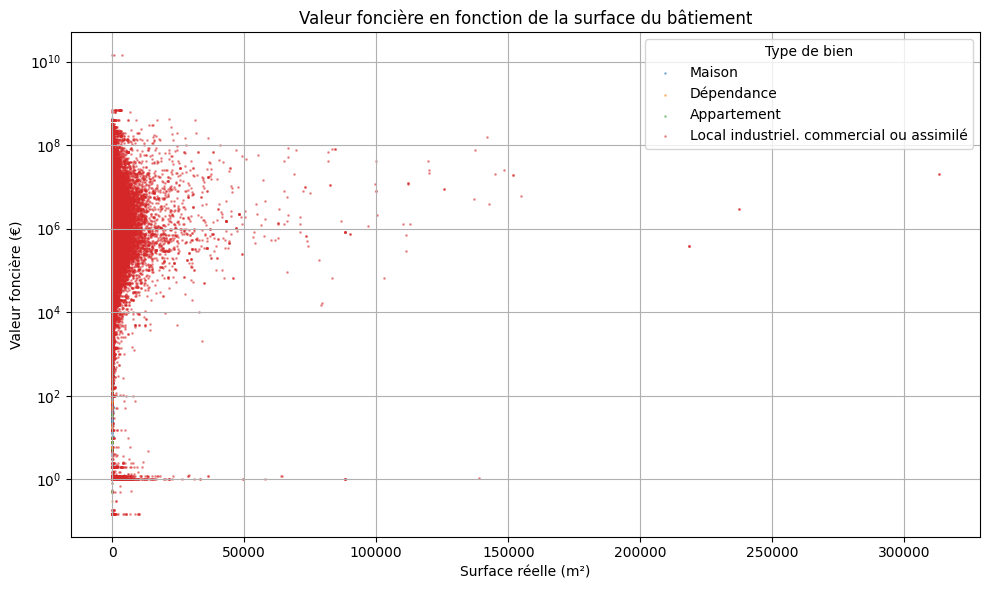

/home/eloi/miniconda3/envs/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


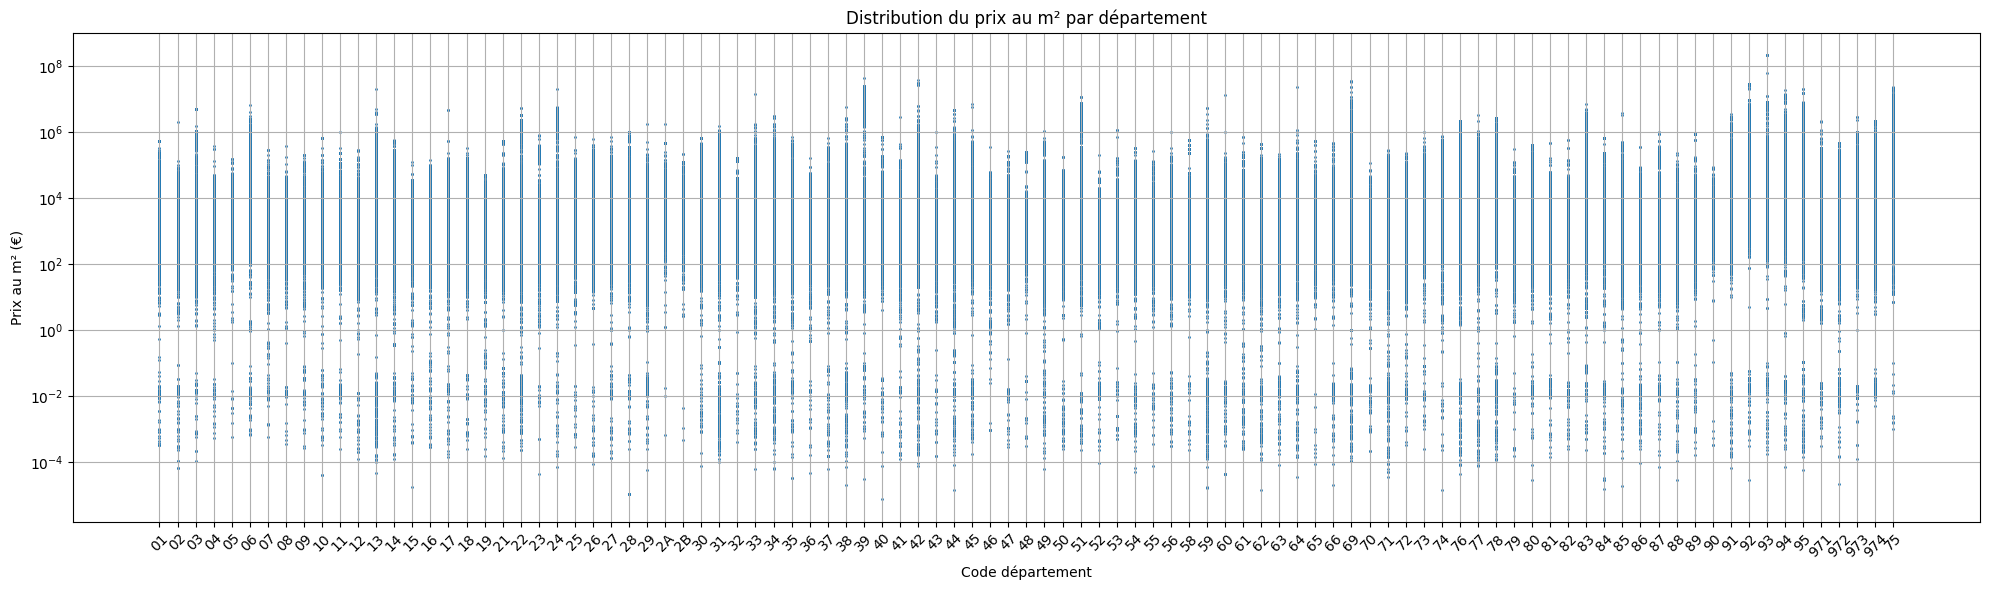

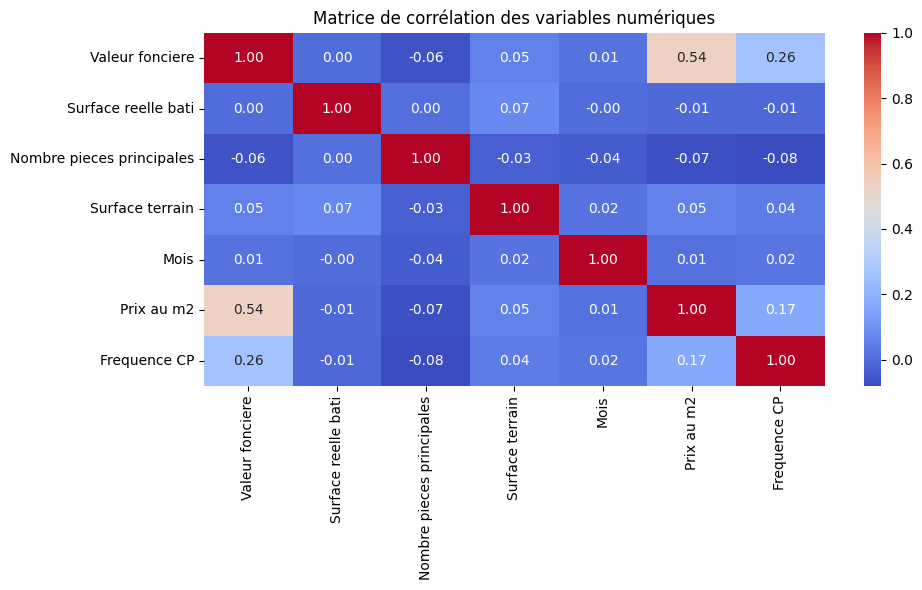

In [4]:
visualize_dataset(data)

### Observations :

1. **Hétérogénéité des types de bien** :
    - Les biens industriels, commerciaux ou assimilés ("Local industriel...") dominent visuellement en valeur foncière, avec des prix atteignant des milliards d’euros.
    - Cette dominance masque la distribution plus "classique" des logements (maisons, appartements), qui sont ceux d'intérêt dans une modélisation résidentielle.

2. **Présence d'outliers extrêmes** :
    - Certaines valeurs foncières dépassent les 10 milliards d'euros, ce qui est extrêmement improbable pour des biens résidentiels.
    - Des valeurs très faibles (à 1€, voire moins) sont aussi présentes, ce qui pourrait signaler des erreurs ou des donations/successions non significatives économiquement.

3. **Corrélation faible** :
    - La matrice de corrélation montre que peu de variables sont fortement corrélées à la valeur foncière. Toutefois, on note :
    - Une corrélation modérée entre le prix au m² et la valeur foncière (`~0.54`), attendue puisque c'est une variable crées à partir de cette dernière.
    - Une légère corrélation avec la fréquence du code postal (`~0.26`), indiquant que la popularité d’une zone pourrait avoir un effet.

4. **Distribution spatiale disparate** :
    - La distribution du prix au m² par département montre des écarts importants, l'utilisation du code postal est donc justifiée.
    - Certains départements présentent des distributions très larges, révélant des zones hétérogènes en termes de valeur foncière.

Sur la base de ces observations :
- **Limiter l’étude aux biens privés uniquement** (`Maison`, `Appartement`) pour éviter la dominance des locaux industriels.
- **Supprimer les ventes avec des valeurs foncières aberrantes** (> 2 millions € et < 10 000 €).
- **Filtrer les surfaces construites trop faibles ou extrêmes** (< 10m² ou > 300m²) pour éliminer les cas non représentatifs.

## Visualisation des données traités :

Shape des features: (1681863, 7)
Colonnes: ['Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Mois', 'Frequence CP']

Aperçu des données:


Code departement Type local  Surface terrain  Surface reelle bati  \
0               01     Maison            695.0                150.0   
1               01     Maison            888.0                 94.0   
2               01     Maison            500.0                 94.0   
3               01     Maison            522.0                 90.0   
6               01     Maison            557.0                110.0   

   Nombre pieces principales  Mois  Frequence CP  
0                          5     7          1376  
1                          4     7           910  
2                          4     7           910  
3                          3     7           910  
6                          5     7           313


Résumé statistique des variables numériques:


Surface terrain  Surface reelle bati  Nombre pieces principales  \
count     1.681863e+06         1.681863e+06               1.681863e+06   
mean      4.409166e+02         9.402760e+01               3.954603e+00   
std       2.649866e+02         4.178635e+01               1.505390e+00   
min       0.000000e+00         1.000000e+01               1.000000e+00   
25%       2.130000e+02         6.700000e+01               3.000000e+00   
50%       4.320000e+02         9.000000e+01               4.000000e+00   
75%       6.210000e+02         1.160000e+02               5.000000e+00   
max       1.000000e+03         3.000000e+02               1.200000e+01   

               Mois  Frequence CP  
count  1.681863e+06  1.681863e+06  
mean   7.434264e+00  1.010199e+03  
std    3.295800e+00  9.277204e+02  
min    1.000000e+00  1.000000e+00  
25%    5.000000e+00  4.220000e+02  
50%    8.000000e+00  7.390000e+02  
75%    1.000000e+01  1.235000e+03  
max    1.200000e+01  9.054000e+03


Répartition des types de biens:
Type local
Maison         1459161
Appartement     222702
Name: count, dtype: int64


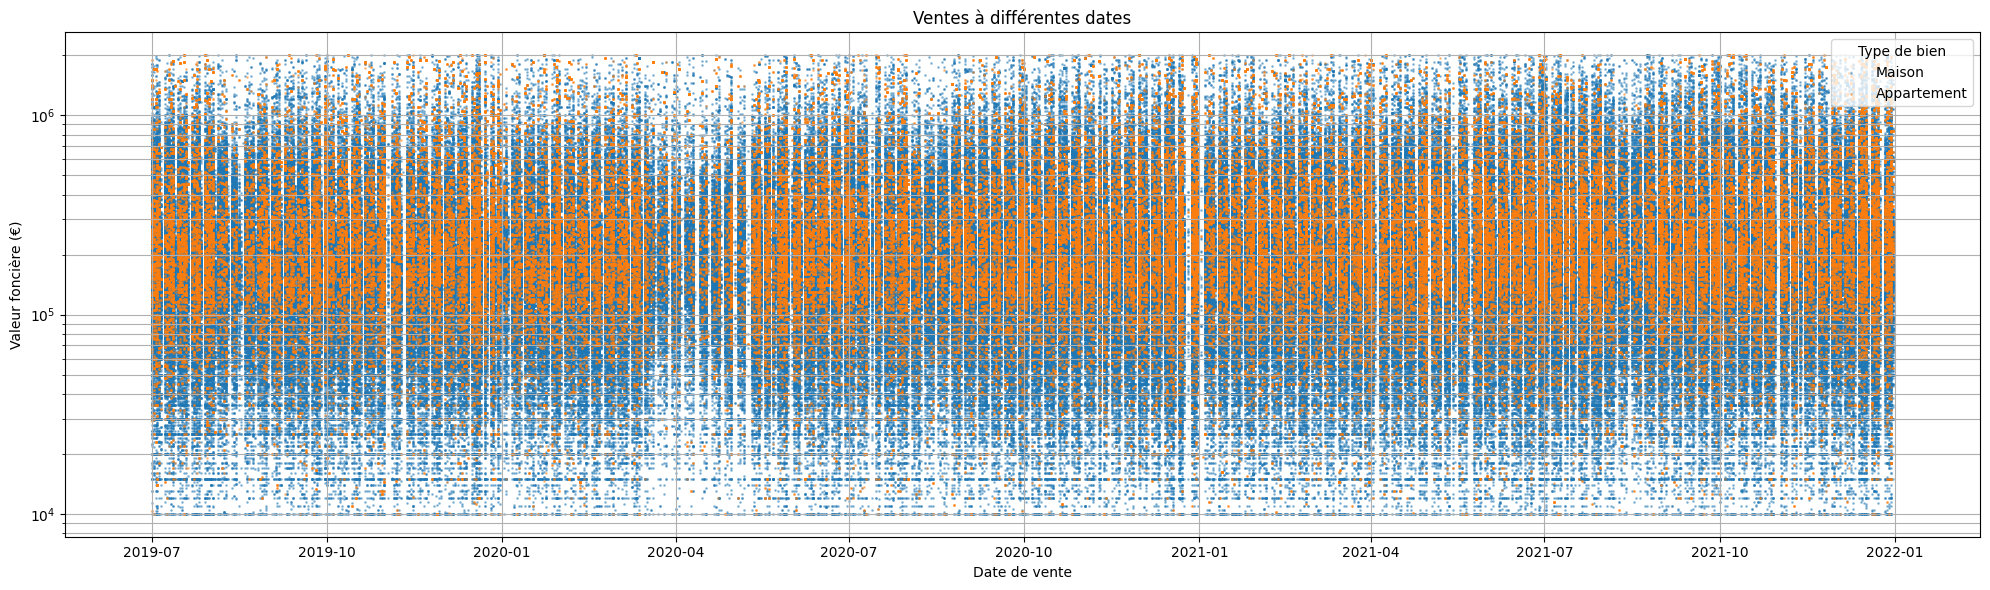

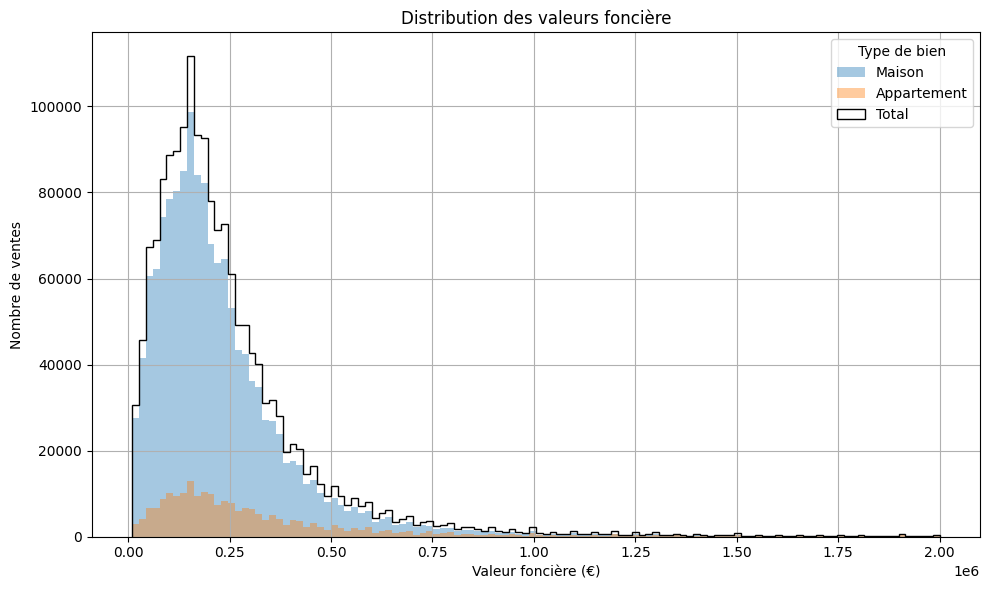

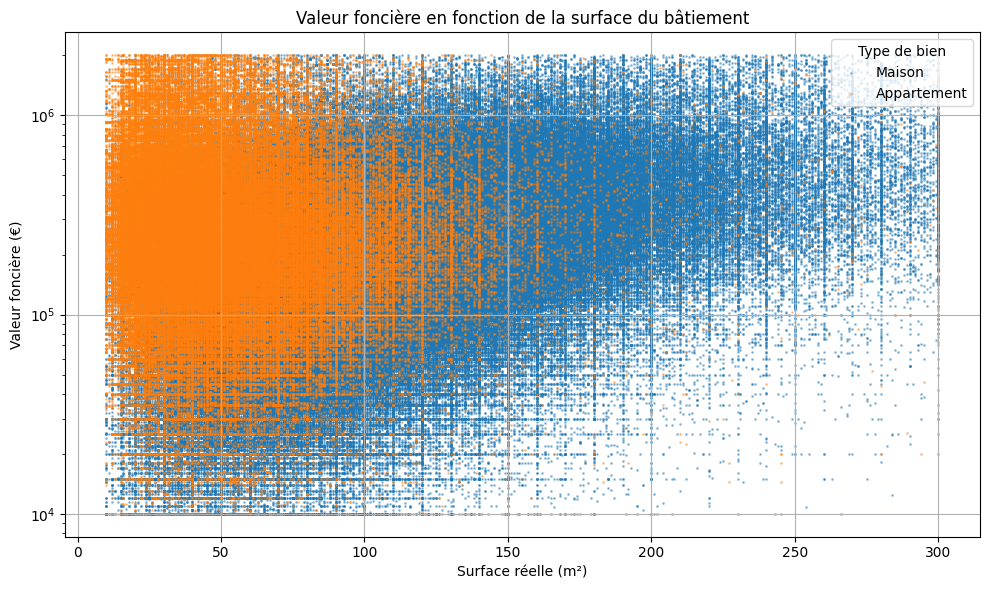

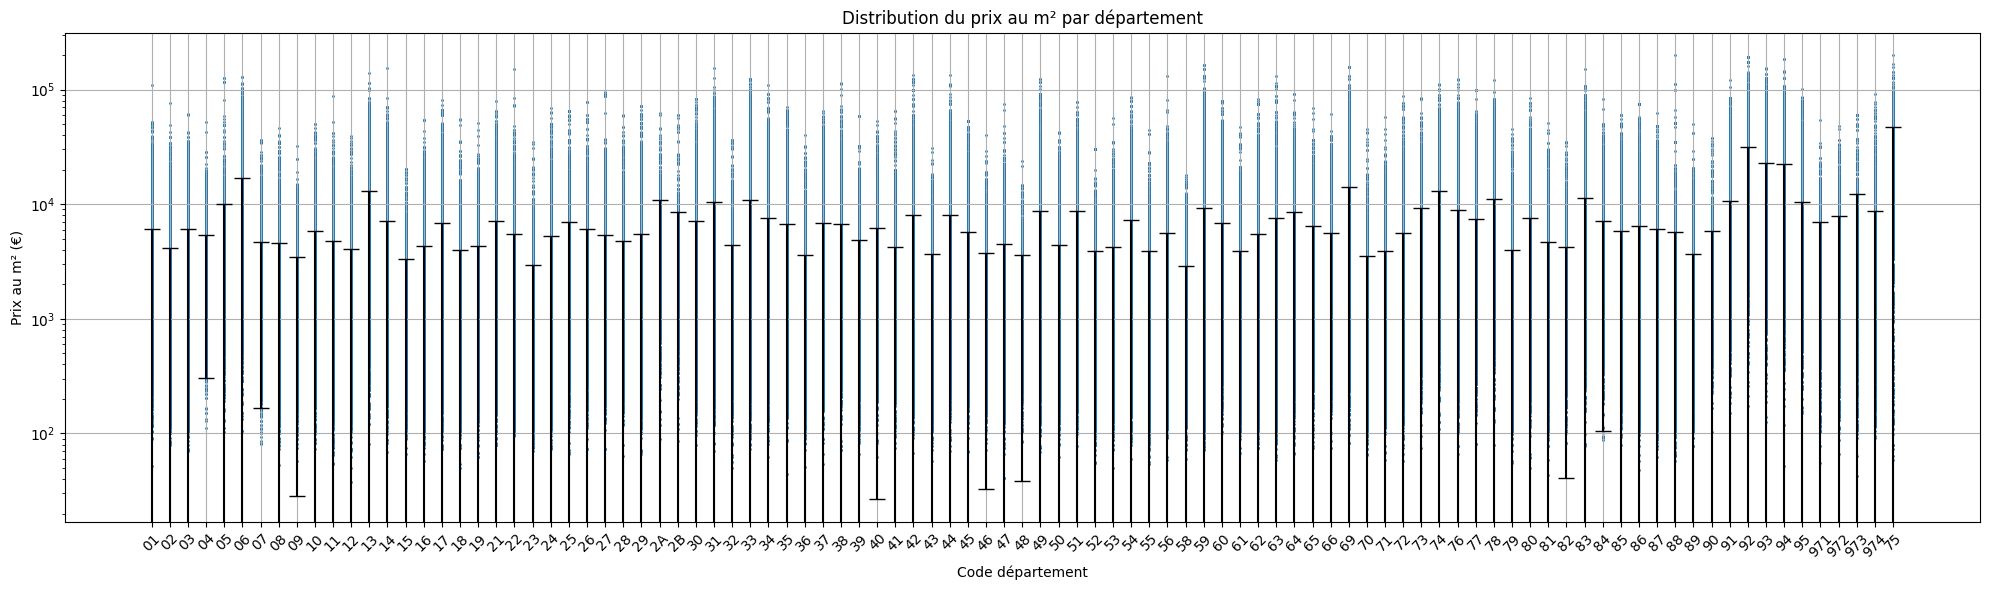

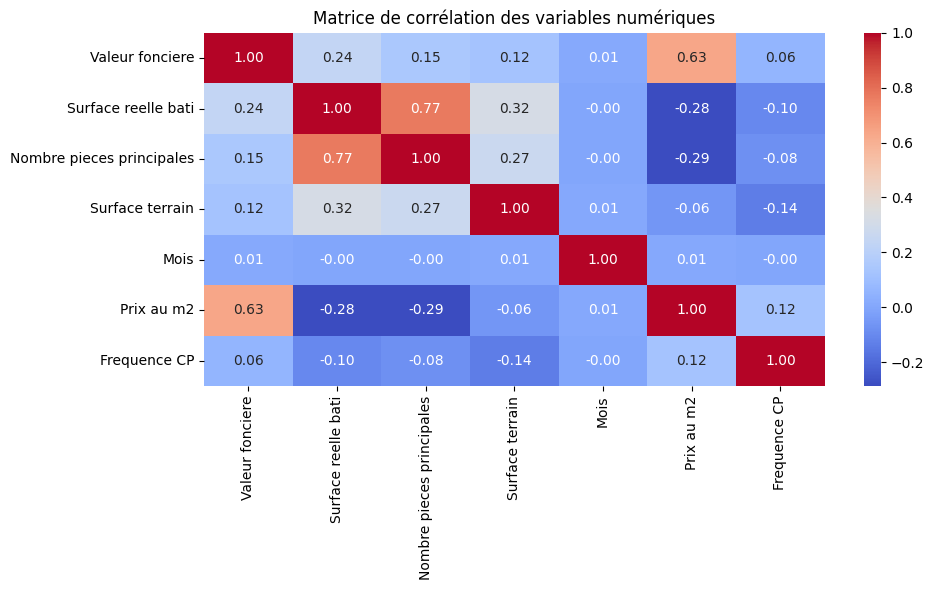

In [5]:
visualize_dataset(data, price= [10_000, 2_000_000], all_local_types= False, surface_bati= [10, 300], surface_terrain= 1000, n_pieces= 12)

### Données filtrées : Analyse post-nettoyage

Après avoir supprimé les biens industriels et les valeurs foncières extrêmes, nous visualisons ici la nouvelle distribution des ventes foncières sur des biens résidentiels uniquement (maisons et appartements).

1. Ventes dans le temps

L’ensemble des transactions apparaît beaucoup plus homogène. On observe :
- Une répartition régulière dans le temps (hormis quelques baisses ponctuelles, probablement liées à des périodes creuses comme les vacances ou le covid-19).
- Une amplitude des prix beaucoup plus contenue (entre ~10 000 € et ~2 M€).

2. Histogramme des valeurs foncières

La distribution est clairement asymétrique (longue traîne à droite), mais beaucoup plus réaliste.
- Le pic est situé entre **150 000 € et 250 000 €**, ce qui peut correspondre aux ventes classiques.
- La majorité des ventes sont donc bien centrées autour de valeurs attendues pour des logements résidentiels.

3. Valeur foncière vs. surface du bâtiement

Le graphe montre désormais une **relation relativement cohérente** entre la surface et le prix :
- Les appartements sont plus petits et tendent à se regrouper à gauche du graphe.
- Les maisons occupent une plage de surface plus étendue.
- La relation n’est pas parfaitement linéaire mais reste significative, ce qui est intéressant pour la modélisation.

4. Prix au m² par département

On constate :
- Des écarts inter-départements très visibles.
- Une concentration des prix au m² autour de valeurs réalistes (quelques centaines à quelques milliers d’euros/m²).
- Les outliers sont encore présents mais bien plus rares.

5. Matrice de corrélation

Les corrélations sont bien plus lisibles maintenant :
- La corrélation entre **surface réelle** et **nombre de pièces** est forte (`~0.77`).
- La corrélation avec les autres variables est faible, ce qui indique que chaque variable pourrait apporter une informatiuon qui lui est propre propre.

**Conclusion** :
Le nettoyage a permis d’obtenir un jeu de données plus cohérent, stable et réaliste pour l'entraînement de modèles. Il réduit l’effet des cas extrêmes qui biaisent l’apprentissage et améliore la capacité du modèle à généraliser.

---

# 3. Nettoyage et filtrage des données

Finalement on garde uniquement :
- les ventes (`Nature mutation == "Vente"`)
- les biens privés (`Maison` et`Appartement`)
- les données utiles : "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales"
- On crée des features à partir des données brutes  pour enrichir nos données : le mois de chaque date de vente ("Mois", pouvant traduire un saisonnalité) ; la frequence d'appartition de chaque code postal ("Frequence CP")

On convertit les données en type utilisables (`float`, `int`, `str`).
On filtre les valeurs de vente, les surfaces, type de locaux et nombre de pièces pour éliminer outliers.

Les données sont maintenant propres, homogènes, prêtes à être utilisées.

In [5]:
dataset, features, target = parse_dataset(data, price= [10_000, 2_000_000], all_local_types= False, surface_bati= [10, 300], surface_terrain= 1000, n_pieces= 12)

---

# 4. Préparation des données

Dans cette étape, nous préparons nos données pour les rendre compatibles avec des modèles de machine learning.

Transformation de nos données:
- **Normalisation des variables numériques** à l’aide de `StandardScaler` pour que chaque feature ait une moyenne nulle et un écart-type de 1.
- **Encodage des variables catégorielles** (`Code departement`, `Type local`) avec `OneHotEncoder`, transformant chaque catégorie en une colonne binaire.

Cela augmente fortement la dimension du dataset, ce qui peut poser des problèmes de performance.

Option d'échantillonnage :
- En raison du volume élevé après encodage, on se réserve la possibilité de **échantillonné** le dataset, notamment pour des tests plus rapide.

Transformation de la variable cible :
- La variable cible (`valeur foncière`) est transformée avec `log1p()` pour **réduire la dispersion des valeurs extrêmes** et potentiellement améliorer les performances des métriques telles que MAE et RMSE.

Split du jeu de données :
- Enfin, nous séparons nos données en ensembles **d'entraînement** et de **test** (et de validation pour les dataset tensorflow).

In [11]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= True,
    sample_size= 1e5,
    log= True,
)
print(f"Input shape: {X_train.shape}")
print(f"Output shape: {y_train.shape}")

Input shape: (64000, 104)
Output shape: (64000,)


---

# 5. Clustering non supervisé

On cherche à regrouper les ventes similaires sans utiliser le prix comme étiquette.

Cela pourrait nour permettre :
- D'identifier des **profils-types** de biens ("petit appartement en ville", "grande maison avec jardin en milieu rurale").
- De détecter des **groupes homogènes** de transactions qui pourraient présenter des tendances de prix différentes.
- De créer une **feature catégorielle "cluster"** utilisable par des modèles supervisés.

On applique **KMeans** sur les données transformées puis on visualise les cluster via PCA 2D et agrégation des statistiques de chaque cluster (moyenne des prix, surfaces, etc).

Pour trouver un bon compromis entre granularité et lisibilité (ie. un nombre de cluster convenable), on trace:

- **L'inertie (somme des distances intra-cluster)** : elle doit diminuer en augmentant `k` avec un palier.
- **Le score de silhouette** : mesure la compacité et séparation des clusters.

Enfin on transforme via PCA + couleurs pour apprécier les séparation.


On s'attends à trouver un **nombre de clusters humain (6 à 10)**, cela permetrait d'observer :
- Une bonne séparation entre appartements et maisons.
- Les différences régionales (Paris vs province).

In [ ]:
def plot_elbow_method(X, k_max= 10):
    """
    Affiche la courbe de l'Elbow method pour estimer le nombre optimal de clusters K.

    Cette méthode permet d'observer la diminution de l'inertie intra-cluster (somme des distances
    aux centroïdes) en fonction du nombre de clusters. Le point de coude suggère un bon compromis
    entre compacité des clusters et complexité.

    Paramètres :
        X : scipy.sparse matrix or np.ndarray
            Données prétraitées (features).

        k_max : int, optionnel
            Nombre maximal de clusters à tester.

    Retour :
        None
            Affiche uniquement un graphique.
    """

    sample_indices = np.random.choice(X.shape[1], size= 10_000)
    X_sampled = X[sample_indices]
    inerties = []
    ks = np.arange(2, k_max + 2)

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters= k, n_init= "auto", random_state= 42)
        kmeans.fit(X_sampled)
        inerties.append(kmeans.inertia_)

    plt.figure(figsize= (10, 4))
    plt.plot(ks, inerties, marker= "o", ls= "--", color= "r")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Inertie intra-cluster")
    plt.title("Elbow methode pour choisir K")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

def plot_silhouette_scores(X, k_max= 10):
    """
    Affiche l'évolution du score de silhouette pour différents nombres de clusters k.

    Le score de silhouette mesure la qualité du clustering : plus le score est proche de 1,
    plus les clusters sont denses et bien séparés. Cette courbe permet de choisir un k
    qui maximise ce critère de séparation.

    Paramètres :
        X : scipy.sparse matrix ou np.ndarray
            Données encodées et normalisées.

        k_max : int, optionnel
            Nombre maximal de clusters à tester.

    Retour :
        None
            Affiche une courbe du score de silhouette pour chaque k.
    """

    sample_indices = np.random.choice(X.shape[1], size= 10_000)
    X_sampled = X[sample_indices]
    silhouette_scores = []
    ks = np.arange(2, k_max + 2)

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters= k, n_init= "auto")
        labels = kmeans.fit_predict(X_sampled)
        score = silhouette_score(X_sampled, labels)
        silhouette_scores.append(score)

    plt.figure(figsize= (10, 4))
    plt.plot(ks, silhouette_scores, marker= "o", ls= "--", color= "r")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score de silhouette")
    plt.title("Score de silhouette pour différents k")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

def summarize_clusters(X, y, k= 10):
    """
    Applique KMeans sur les données traitées et calcule des statistiques descriptives par cluster.

    Paramètres :
        X : pd.DataFrame
            Données d'entrée avec les variables d'origine non encodées.
        
        y : pd.Series ou np.ndarray
            Variable cible à inclure dans le résumé (valeur foncière).

        k : int, optionnel
            Nombre de clusters à utiliser pour KMeans.

    Retour :
        summary : pd.DataFrame
            Tableau résumant les statistiques de chaque cluster.
    """

    X_processed = process_features(X)
    kmeans = KMeans(n_clusters= k)
    labels = kmeans.fit_predict(X_processed)
    df_clusters = X.copy()
    df_clusters["cluster"] = labels
    df_clusters["target"] = y

    dict = {
        "Type local": lambda x: x.mode()[0],
        "Code departement": lambda x: x.mode()[0],
        "Surface terrain": ["mean", "std"],
        "Surface reelle bati": ["mean", "std"],
        "Nombre pieces principales": "mean",
        "Frequence CP": "mean",
        "Mois": "mean",
        "target": ["mean", "std"]
    }

    summary = df_clusters.groupby("cluster").agg(dict).round(2)

    summary.head()
    return summary

100%|██████████| 100/100 [03:51<00:00,  2.32s/it]


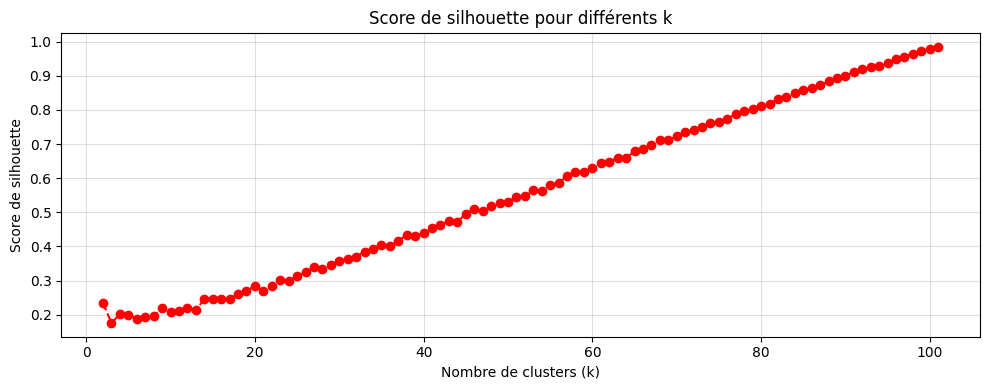

In [9]:
plot_silhouette_scores(X_train, 100)

100%|██████████| 100/100 [00:06<00:00, 14.97it/s]


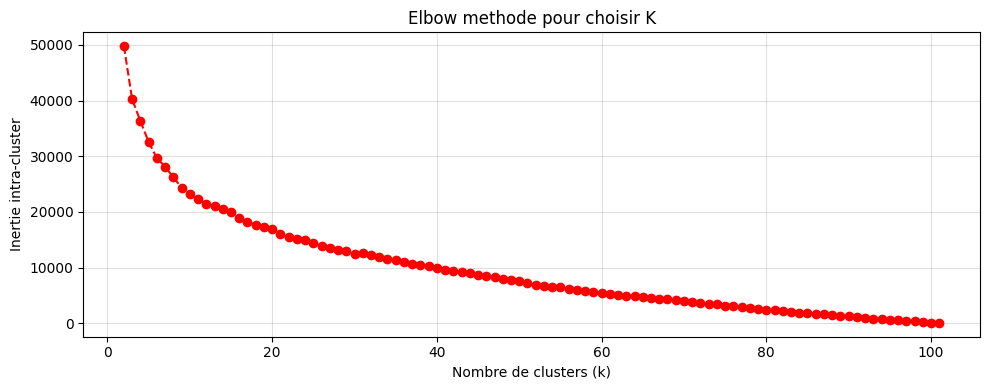

In [10]:
plot_elbow_method(X_train, 100)

In [13]:
k = 10
kmeans = KMeans(n_clusters= k)
cluster_labels = kmeans.fit_predict(X_train)
# print("Inertie :", kmeans.inertia_)
# print("Silhouette score :", silhouette_score(X_train, cluster_labels))

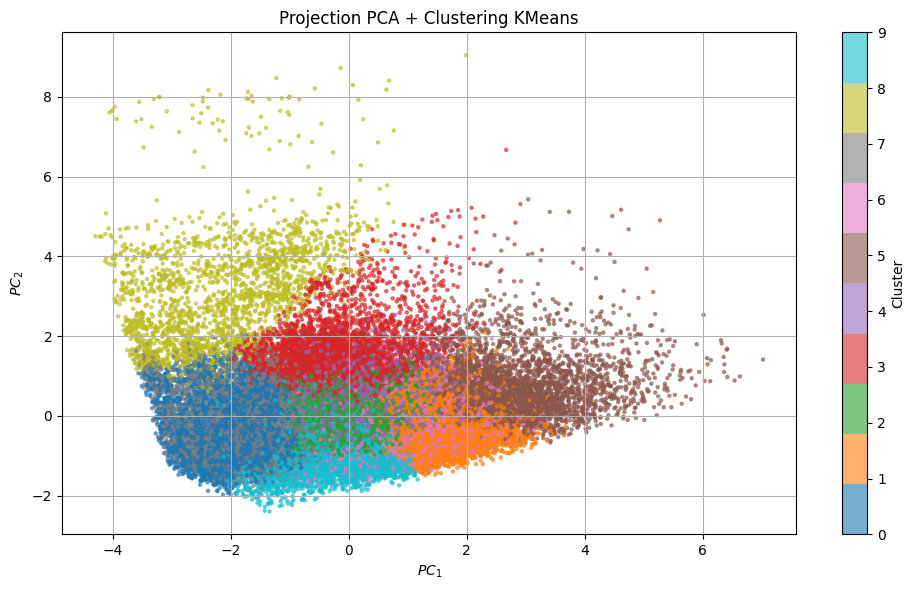

In [17]:
pca = PCA(n_components= 2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", s=5, alpha=0.6)
plt.colorbar(label= "Cluster")
plt.title("Projection PCA + Clustering KMeans")
plt.xlabel(r"$PC_1$")
plt.ylabel(r"$PC_2$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
summarize_clusters(dataset[features], dataset[target])

Type local Code departement Surface terrain          \
            <lambda>         <lambda>            mean     std   
cluster                                                         
0             Maison               59          189.97  114.84   
1             Maison               44          672.04  158.86   
2             Maison               59          361.46  142.30   
3        Appartement               59          222.91  159.82   
4             Maison               59          245.79  149.74   
5             Maison               59          563.46  228.18   
6             Maison               59          373.52  190.89   
7             Maison               59          244.81  197.25   
8             Maison               59          622.07  191.14   
9             Maison               33          804.56  132.12   

        Surface reelle bati        Nombre pieces principales Frequence CP  \
                       mean    std                      mean         mean   
cluster                                                                     
0                     67.17  18.63                      2.99       702.99   
1                     66.65  19.73                      2.79       720.88   
2                    108.43  22.07                      4.71       678.42   
3                     37.71  15.19                      1.69      1437.60   
4                     74.40  22.12                      3.30       771.50   
5                    186.03  36.78                      6.63       872.71   
6                     96.53  25.98                      4.32      2394.00   
7                     69.68  34.56                      3.24      4746.43   
8                    110.19  25.57                      4.62       776.06   
9                    114.98  23.81                      4.70       768.35   

         Mois     target             
         mean       mean        std  
cluster                              
0        9.77  167178.78  165737.42  
1        8.59  215458.29  219343.77  
2        9.22  247241.47  180698.31  
3        7.52  313786.71  311630.94  
4        3.24  184222.26  173032.98  
5        7.53  425352.67  318606.41  
6        8.01  245813.00  183234.58  
7        7.31  250911.89  220417.04  
8        3.13  252657.21  180686.70  
9        9.33  264748.58  179212.99

## Conclusion

1. **Score de silhouette** :
    Le score augmente progressivement, ce qui indique une structure continue plutôt que des groupes bien séparés.

2. **Méthode du coude** :
    Un coude est visible entre `k = 8` et `k = 12`, choix raisonnable pour interprétation humaine.

Pour k= 10, les cluster ne reflètent pas un segment de marché identifiable, les clusters sont presque tous centré autour des maisons dans le département 59.

Les variables catégorielles n'étant pas représentées via le clustering.

Il faudrait tester d'autres algorithmes de clustering, ou bien explorer des clusters spécifiques par catégories.

Ces segments illustrent différentes réalités du marché (taille, prix, localisation) qui peuvent être réinjectées dans des modèles supervisés, via un `cluster_id` comme variable catégorielle.

---

# Analyse en Composantes Principales (PCA)

On applique une Analyse en Composantes Principales afin de réduire la dimensionnalité du jeu de données tout en conservant un maximum d'infomration (de variance).

L’objectif est double :
- Visualiser les données dans un espace 2D pour explorer leur structure, détecter des regroupements ou une forme de séparation naturelle.
- Réduire la dimension des données pour accélérer les algorithmes ou d’éviter l’overfitting si certaines features sont fortement corrélées.

Pour choisir combien de composantes principales conserver, nous analysons la **variance expliquée cumulée**. On cherche un compromis entre :
- Conserver suffisamment de variance (80% minimum),
- Réduire au maximum le nombre de dimensions pour limiter le bruit et accélérer les calculs.

Enfin on projet les données sur des couples de composantes principales, on s'attends à :
- Observer des sous-groupes correspondant à des types de biens, des localisations, ou des gammes de prix,
- Identifier d’éventuelles anomalies,

In [ ]:
def plot_explained_variance(X, n_components= 10):
    """
    Affiche la variance expliquée cumulée en fonction du nombre de composantes principales.

    Cette fonction permet de visualiser la quantité d'information (variance) conservée
    lors d'une réduction de dimension par PCA.

    Paramètres :
        X : np.ndarray
            Données numériques centrées-réduites (ou à normaliser avant usage si nécessaire).
        
        n_components : int, optionnel
            Nombre de composantes principales à calculer.

    Retour :
        None
            Affiche uniquement un graphique.
    """

    pca = PCA(n_components= n_components)
    pca.fit(X)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    n = np.arange(1, len(cumulative_variance) + 1)

    plt.figure(figsize= (8, 4))
    plt.plot(n, cumulative_variance, marker= ".", ls= "")
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée cumulée par PCA")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

def plot_pc(X_pca, y):
    """
    Affiche les projections des trois premières composantes principales issues de la PCA,
    colorées selon la variable cible (valeur foncière).

    Cette visualisation permet d'examiner la répartition des données après PCA
    et de détecter visuellement des structures, regroupements ou tendances
    associées à la variable cible.

    Paramètres :
        X_pca : np.ndarray
            Résultat de la transformation PCA.
        
        y : array-like
            Variable cible associée aux échantillons.

    Retour :
        None
            Affiche une figure avec 3 sous-graphes en 2D.
    """

    y = np.expm1(y)
    plt.figure(figsize= (12, 4))

    plt.subplot(131)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c= y, s= 1, alpha= .4)
    plt.xlabel(r"$PC_0$")
    plt.ylabel(r"$PC_1$")
    plt.grid(True, alpha= .4)

    plt.subplot(132)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 2], c= y, s= 1, alpha= .4)
    plt.xlabel(r"$PC_0$")
    plt.ylabel(r"$PC_2$")
    plt.grid(True, alpha= .4)
    plt.title("Projection PCA colorée par valeur foncière")

    plt.subplot(133)
    scatter = plt.scatter(X_pca[:, 1], X_pca[:, 2], c= y, s= 1, alpha= .4)
    plt.colorbar(scatter, label= "Valeur foncière (€)")
    plt.xlabel(r"$PC_1$")
    plt.ylabel(r"$PC_2$")
    plt.grid(True, alpha= .4)

    plt.tight_layout()
    plt.show()
    return

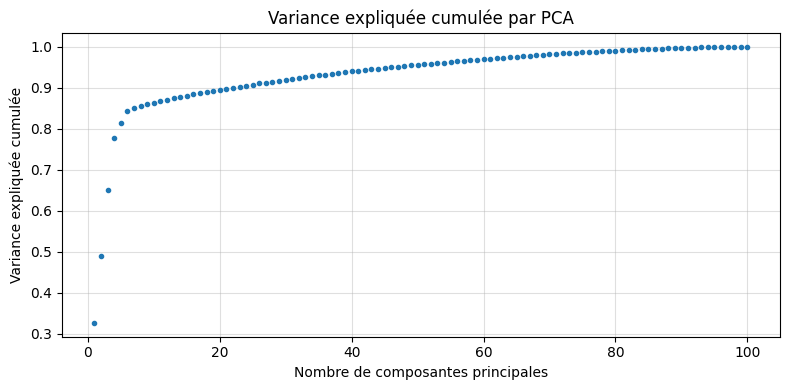

In [116]:
plot_explained_variance(X_train, 100)

In [124]:
pca = PCA(6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

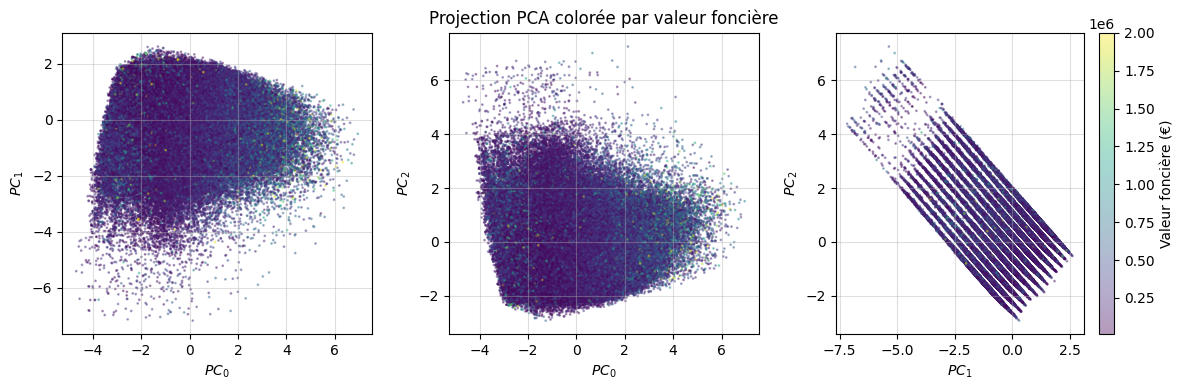

In [125]:
plot_pc(X_train_pca, y_train)

Après réduction de dimension par PCA, nous avons projeté les données sur les trois premières composantes principales, en colorant les points selon la valeur foncière associée.

Observations :
- Les six premières composantes expliquent déjà **plus de 80% de la variance**.
- On observe une **structure en bandes marquée** entre les composantes $PC_1$ et $PC_2$, ce qui indique une forte contribution de variables catégorielles.
- En colorant par valeur foncière, on ne distingue pas de sous-ensembles pouvant indiquer que certains axes de la PCA contiennent des informations sur le prix.

On peut maintenant utiliser ces composantes comme **features d'entrée pour des modèles supervisés**. (voir du clustering)

---

# Modélisation : Random Forest

Le modèle **Random Forest Regressor** est un choix pertinent pour notre tâche de prédiction de valeur foncière :
- **Robustesse aux outliers** : contrairement à des modèles linéaires Random Forest est peu sensible aux valeurs extrêmes (même si on a traité les données).
- **Gestion des relations non linéaires** : il peut capturer facilement des relations complexes entre les variables (interactions non linéaires entre surface, localisation, saisonnalité, etc).

Pour évaluer la performance du modèle, plusieurs métriques sont utilisées :

- **R² score** : mesure la proportion de variance expliquée par le modèle. Plus proche de 1, meilleur est le modèle.
- **MAE (Mean Absolute Error)** : erreur moyenne absolue en euros, plus lisible ici.
- **RMSE (Root Mean Squared Error)** : pénalise plus les grandes erreurs.

Ces métriques sont comparées sur le jeu d'entraînement et de test pour détecter sur-apprentissage ou sous-apprentissage.

La Random Forest possède plusieurs **hyperparamètres** à ajuster pour optimiser sa performance :

- `n_estimators` : nombre d’arbres dans la forêt (plus il y en a, plus le modèle est stable mais coûteux).
- `max_depth` : profondeur maximale d’un arbre.
- `min_samples_split` / `min_samples_leaf` : régularisation de la taille minimale des noeuds internes / feuilles.
- `max_features` : nombre de variables considérées à chaque division (agit comme un régularisateur).

Une **recherche croisée sur un sous-échantillon** est utilisée pour identifier la meilleure combinaison des paramètres `n_estimators` et `max_depth` via le **R² score**.

In [ ]:
def evaluate_rf_params(X_train, X_test, y_train, y_test, sampled= True):
    """
    Évalue les performances d'un modèle RandomForestRegressor pour différentes combinaisons 
    de n_estimators et max_depth, et affiche la meilleure combinaison en fonction du R².

    Paramètres :
        X_train : np.ndarray
            Données d'entraînement.

        X_test : np.ndarray
            Données de test.

        y_train : np.ndarray
            Cible d'entraînement (log-transformée).

        y_test : np.ndarray
            Cible de test (log-transformée).

        sampled : bool, optionnel
            Si True, échantillonne les données pour accélérer la recherche.

        sample_size : int, optionnel
            Nombre de points utilisés en mode échantillonné.

    Retour :
        None
            Affiche les meilleurs hyperparamètres trouvés et le score R² associé.
    """

    if sampled is True:
        sample_indices_train = np.random.choice(X_train.shape[0], size= 10_000)
        sample_indices_test = np.random.choice(X_test.shape[0], size= 10_000)
        X_train = X_train[sample_indices_train]
        X_test = X_test[sample_indices_test]
        y_train = y_train.iloc[sample_indices_train]
        y_test = y_test.iloc[sample_indices_test]


    r2_max = 0
    n_max, m_max = 0, 0
    for n in tqdm(range(10, 105, 5)):
        for m in range(15, 105, 5):
            model = RandomForestRegressor(n_estimators= n, max_depth= m, n_jobs= -1, random_state= 42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_real = np.expm1(y_pred)
            y_test_real = np.expm1(y_test)
            r2 = r2_score(y_test_real, y_pred_real)
            if r2 > r2_max:
                r2_max = r2
                n_max, m_max = n, m
    print(f"n= {n_max}, m= {m_max}, R²= {r2_max:.2f}")

    return

def show_rf_stats(X_test, y_test, model):
    """
    Affiche les performances d'un modèle Random Forest sur un jeu de test,
    en échelle réelle, avec un graphique de comparaison entre valeurs prédites et observées.

    Paramètres :
        X_test : np.ndarray
            Données d'entrée pour le test.

        y_test : array-like
            Variable cible (log-transformée).

        model : sklearn.ensemble.RandomForestRegressor
            Modèle entraîné.

    Retour :
        None
            Affiche les métriques et le nuage de points log-log.
    """

    y_pred = model.predict(X_test)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = root_mean_squared_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)
    print(f"MAE : {mae:.2f} €")
    print(f"RMSE : {rmse:.2f} €")
    print(f"R² : {r2:.4f}")

    plt.figure(figsize= (8, 4))
    plt.scatter(y_test_real, y_pred_real, alpha= .3, s= 1)
    plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
    plt.xlabel("Valeur réelle (€)")
    plt.ylabel("Valeur prédite (€)")
    plt.title("Prédictions RF vs Réel")
    plt.grid(True)
    plt.loglog()
    plt.tight_layout()
    plt.show()

    return

In [7]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= False,
    sample_size= 5e5,
    log= True,
)

In [178]:
evaluate_rf_params(X_train, X_test, y_train, y_test, sampled= False)

100%|██████████| 19/19 [1:53:33<00:00, 358.59s/it]

n= 100, m= 95, R²= 0.42


Bests parameters :
- n= 100, m= 95, R²= 0.42

In [8]:
n_estimators = 35
max_depth = 55

# n_estimators = 100
# max_depth = 95

In [9]:
rf = RandomForestRegressor(n_estimators= n_estimators, max_depth= max_depth, n_jobs= -1)

In [10]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1)

MAE : 74100.50 €
RMSE : 130296.48 €
R² : 0.6410


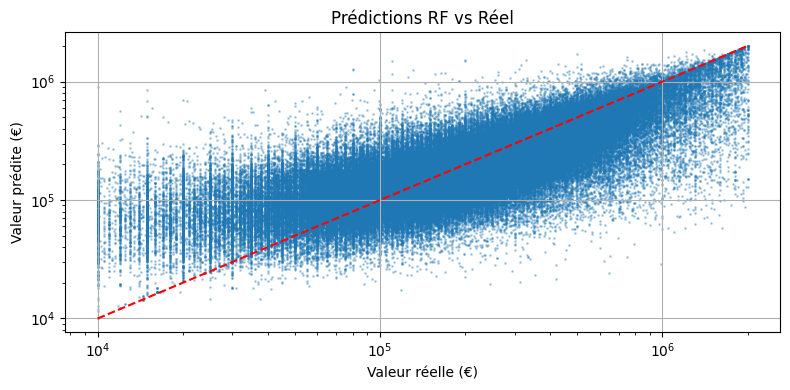

In [11]:
show_rf_stats(X_test, y_test, rf)

Le modèle Random Forest donne des résultats contrastés selon la taille du jeu d'entraînement :
- **Sur un échantillon réduit**, les performances sont limitées avec un **R² = 0.4**, ce qui montre que le modèle peine à capturer correctement la variance de la variable cible.
- **Sur l’ensemble complet des données** (jusqu'à 2021), le modèle atteint un **R² = 0.6**, et donc une bien meilleure capacité à généraliser.
- **MAE et RMSE** relativement stables (~80 000€ et ~125 000€), même lorsque le modèle est entraîné sur l’ensemble des données. Cela suggère que le **risque d’overfitting** est limité.

La recherche a permis d’identifier des hyperparamètres efficaces (pour le jeu complet) :
- `n_estimators = 35`
- `max_depth = 55`

Ces valeurs semblent fournir un bon compromis entre **performance**, **temps de calcul** et **capacité de généralisation**.

La visualisation des **prédictions de RF vs valeurs réelles** montre :

- Le modèle sous-estime légèrement les valeurs élevées (difficulté à capter la longue queue des très hautes valeurs foncières).
- Génère une dispersion importante pour les petites valeurs foncières.

L'estimation des autres hyperparamètres ou l'utilisation d'une autre métrique pour l'estimation sont des pistes d'amélioration.

---

## PCA + Random Forest

On regarde maintenant si la **réduction de dimension** via **PCA** peut **améliorer les performances** du modèle Random Forest.

Réduire la complexité des données pour :
- diminuer le **temps d'entraînement** du modèle,
- réduire les **ressources mémoire utilisées**,
- potentiellement **améliorer la généralisation** du modèle.

Nous avons utilisé **6 à 10** composantes issues de la PCA, expliquant de **80 à 90 %** de la variance totale.
Le modèle RandomForestRegressor est entraîné avec les **mêmes hyperparamètres** :
- `n_estimators = 35`
- `max_depth = 55`
L’évaluation est réalisée sur un **échantillon de test** ainsi que sur l’**ensemble des données**.

In [126]:
rf_pca = RandomForestRegressor(n_estimators= n_estimators, max_depth= max_depth, n_jobs= -1)

In [127]:
rf_pca.fit(X_train_pca, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1)

MAE : 118501.55 €
RMSE : 201065.35 €
R² : 0.1465


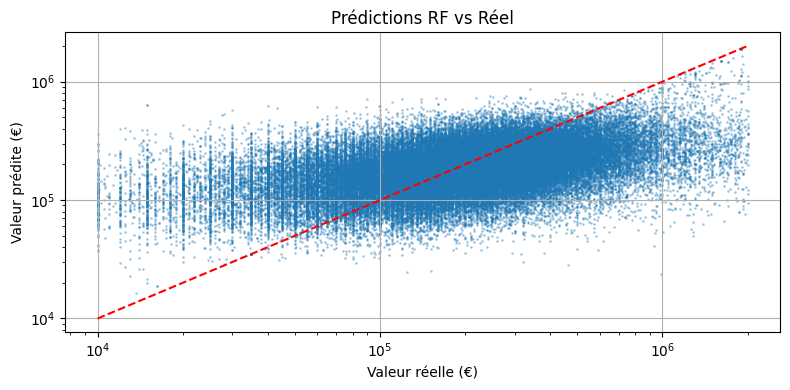

In [128]:
show_rf_stats(X_test_pca, y_test, rf_pca)

### Résultats :
- **R² sur échantillon de test** : **0.15 à 0.2**
- **R² sur le jeu complet** : **~0.3**

Ces performances sont nettement inférieures à celles obtenues sans PCA :
- Avec toutes les features originales, le modèle atteignait **R² = 0.6** sur le jeu complet.
- La transformation par PCA semble avoir supprimé des informations nécessaires à la prédiction malgré la forte variance expliquée cumulée.

La PCA est ici contre-productive pour un modèles comme la Random Forest et avec nos donnée.

Il est donc préférable de conserver les features brutes plutôt que leurs projections, au moins pour ce modèle.

---

# Régression par MLP (Multi-Layer Perceptron) et ResMLP

On utilise maintenant des réseaux de neurones profonds pour la prédiction de la **valeur foncière**. 

Deux type de réseaux seront utilisés :

- Un **MLP (Multi-Layer Perceptron)**, simple réseau dense avec des couches cachées, il est capable de :
    - modéliser des fonctions non linéaires complexes (notre cas),
    - s'adapter à de grands ensembles de données (notre cas),
    - tirer parti de l’optimisation GPU pour accélérer l'entraînement.

- Un **ResMLP (Residual MLP)** il ajoute des **connexions résiduelles (skip connections)** entre les couches, ce qui permet :
    - de **faciliter l’apprentissage** dans les réseaux profonds,
    - de **limiter le phénomène de vanishing gradients** (gradient trop petit dans les prmières couches et donc le modèle n'apprends plus),
    - d’eventuellement **améliorer la stabilité et la vitesse de convergence**.

Les réseaux entraînés partagent des configurations communes :
- **Nombre de couches** : 3 à 10 couches selon les tests (un reseau plus profond pourrait apprendre des relations plus complexes au risque d'un over-fiting).
- **Taille des couches** : jusqu’à **512 neurones**, parfois en décroissance (`layer_type= "shrinking"`).
- **Fonction d’activation** : ReLU (non linéaire et empèche le vanishing gradient)
- **Regularisation** :
  - Dropout (0.3) (réduit le risque d'over-fiting)
  - BatchNormalization
- **Fonction de coût** : 
    - `mse`,
    - `logcosh` (plus robuste aux outliers que MSE),
    - `Huber` (combine MAE et MSE en fonction d'un paramètre alpha)
- **Optimiseur** : `Adam`, avec `learning_rate = 1e-3` (ajuste les poids avec inertie et converge rapidement).
    - Le learning rate sera réduit dynamiquement avec `ReduceLROnPlateau` et un facteur de 0.5 si la loss stagne au bout de 5 epoch.
- **EarlyStopping** : arrête l'entrainement si il n'y a aucune amélioration au bout de 10 epochs (et réstauration des poids de la meilleur loss).

Le **batch size est grand (ex: 1024)** pour exploiter efficacement le **GPU** et minimiser le temps d'entraînement.
  - Le chargement se fait via `tf.data.Dataset` avec `prefetch` pour **pousser les données en VRAM**.


On utilisera un **échantillon de 500 000 lignes** pour réduire le temps de calcul.

Les données cibles sont transformées avec `log1p()` pour stabiliser la distribution et réduire l’influence des valeurs extrêmes.

Les **métriques utilisées** sont :
  - `MAE` (Mean Absolute Error)
  - `RMSE` (Root Mean Squared Error)
  - `R²` (coefficient de détermination)

On va comparer les performances des MLP et ResMLP (avec différents hyperparamètres) face au Random Forest et essayer d’**approcher ou dépasser un R² de 0.6**.

In [ ]:
def create_tf_dataset(X, y, batch_size= 2048):
    """
    Prépare un dataset TensorFlow pour l'entraînement sur GPU.

    Paramètres :
        X : np.ndarray
            Matrice des features.

        y : array-like
            Target correspondant aux entrées X.

        batch_size : int, optionnel
            Taille des batches pour l'entraînement.

    Retour :
        tf.data.Dataset
            Dataset TensorFlow prêt à être utilisé, avec préchargement automatique (`prefetch`).
    """

    X_array = X.toarray()
    dataset = tf.data.Dataset.from_tensor_slices((X_array, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

    return dataset

def show_nn_stats(dataset_test, y_test, model, model_history):
    """
    Affiche les performances et les courbes d'apprentissage d'un modèle de régression neuronale.

    Paramètres :
        dataset_test : tf.data.Dataset
            Jeu de test sous forme de dataset TensorFlow (features, batchés).

        y_test : array-like
            Variable cible réelle du jeu de test (log-transformé).

        model : tf.keras.Model
            Modèle entraîné.

        model_history : tf.keras.callbacks.History
            Historique d'entraînement.

    Retour :
        None
            Affiche métriques et figures.
    """

    y_pred = model.predict(dataset_test)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)
    lrate = model_history.history["learning_rate"]

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = root_mean_squared_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)
    print(model.evaluate(dataset_test))
    print(f"MAE : {mae:.2f} €")
    print(f"RMSE : {rmse:.2f} €")
    print(f"R² : {r2:.4f}")
    print(f"lrate : [{lrate[0]}, {lrate[-1]}]")

    plt.figure(figsize= (12, 8))
    plt.subplot(211)
    plt.scatter(y_test_real, y_pred_real, alpha= .3, s= 1)
    plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
    plt.xlabel("Valeur réelle (€)")
    plt.ylabel("Valeur prédite (€)")
    plt.title("Prédictions "+ model.name + " vs Réel")
    plt.grid(True)
    plt.loglog()

    plt.subplot(223)
    plt.plot(model_history.history["loss"], label= "training")
    plt.plot(model_history.history["val_loss"], label= "validation")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()

    plt.subplot(224)
    plt.plot(model_history.history["learning_rate"])
    plt.xlabel("epochs")
    plt.ylabel("lrate")
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return

def build_mlp_model(input_shape= 0, n_layers= 3, layer_size= 512, lrate= 1e-3, loss_function= "mse", layer_type= "constant"):
    """
    Construit un modèle de réseau de neurones multicouche (MLP) pour la régression.
    Deux types de géométrie de couches sont possibles : constante ou décroissante.

    Paramètres :
        input_shape : int
            Nombre de features en entrée.

        n_layers : int, optionnel
            Nombre total de couches cachées (hors couche de sortie).

        layer_size : int, optionnel
            Taille de la première couche cachée.

        lrate : float, optionnel
            Taux d'apprentissage pour l'optimiseur Adam.

        loss_function : str, optionnel (mse, log_cosh, huber)
            Fonction de perte à utiliser.

        layer_type : str, optionnel
            Stratégie de taille des couches cachées :
            - "constant" : même taille pour toutes.
            - "shrinking" : taille divisée par 2 à chaque couche.

    Retour :
        model : tf.keras.Model
            Modèle compilé prêt à l'entraînement.
    """

    if loss_function == "mse":
        loss = "mse"
    elif loss_function == "log_cosh":
        loss = LogCosh()
    elif loss_function == "huber":
        loss = Huber(delta= .3)
    else:
        print(f"Error: Unknown loss function, {loss_function}.")
        return -1

    model = Sequential(name= "MLP")
    model.add(Input(shape = (input_shape,)))
    model.add(Dense(layer_size, activation= "relu"))

    if layer_type == "constant":
        for _ in range(n_layers - 1):
            model.add(Dense(layer_size, activation= "relu"))
            model.add(BatchNormalization())
            model.add(Dropout(.3))
    elif layer_type == "shrinking":
        for n in range(1, n_layers - 1):
            model.add(Dense(int(layer_size / (2 ** n)), activation= "relu"))
            model.add(BatchNormalization())
            model.add(Dropout(.3))
    else:
        print(f"Error: Unknown layer type, {layer_type}.")
        return -1

    model.add(Dense(1))

    model.summary()
    model.compile(optimizer= Adam(learning_rate= lrate), loss= loss, metrics= ["mae"])

    return model

def build_resmlp_model(input_shape= 0, n_layers= 1, layer_size= 512, lrate= 1e-3, loss_function= "mse"):
    """
    Construit un réseau de neurones MLP avec connexions résiduelles (resMLP).

    L'ajout d'un chemin court-circuit entre l'entrée et la sortie permet d'apprendre
    plus efficacement en facilitant la rétropropagation.

    Paramètres :
        input_shape : int
            Nombre de features en entrée.

        n_layers : int, optionnel
            Nombre total de blocs résiduels (>=1).

        layer_size : int, optionnel
            Nombre total de couches cachées (hors couche de sortie).

        lrate : float, optionnel
            Taux d'apprentissage pour l'optimiseur Adam.

        loss_function : str, optionnel ("mse", "log_cosh", "huber")
            Fonction de perte à utiliser.

    Retour :
        model : tf.keras.Model
            Modèle compilé prêt à l'entraînement.
    """

    if loss_function == "mse":
        loss = "mse"
    elif loss_function == "log_cosh":
        loss = LogCosh()
    elif loss_function == "huber":
        loss = Huber(delta= .3)
    else:
        print("Error: Unknown loss function.")
        return -1

    input_layer = Input(shape= (input_shape,))
    x = Dense(layer_size, activation= "relu")(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(.3)(x)
    for _ in range(n_layers - 1):
        x_res = Dense(layer_size, activation= "relu")(x)
        x_res = BatchNormalization()(x_res)
        x_res = Dropout(.3)(x_res)
        x = Add()([x, x_res])
    shortcut = Dense(1)(input_layer)
    main_output = Dense(1)(x)
    output_layer = Add()([main_output, shortcut])

    model = Model(inputs= input_layer, outputs= output_layer, name= "resMLP")
    model.summary()
    model.compile(optimizer= Adam(learning_rate= lrate), loss= loss, metrics= ["mae"])

    return model

In [ ]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= True,
    sample_size= 5e5,
    log= True,
)

In [13]:
batch_size= 4096
epochs= 200
input_shape = X_train.shape[1]

dataset_test = create_tf_dataset(X_test, y_test, batch_size)
dataset_train = create_tf_dataset(X_train, y_train, batch_size)
dataset_vali = create_tf_dataset(X_vali, y_vali, batch_size)

I0000 00:00:1746125117.214509  187946 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6
2025-05-01 20:45:17.223656: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 279862336 exceeds 10% of free system memory.
2025-05-01 20:45:18.016855: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 279862336 exceeds 10% of free system memory.
2025-05-01 20:45:22.225012: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 895558144 exceeds 10% of free system memory.
2025-05-01 20:45:23.828881: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 895558144 exceeds 10% of free system memory.


In [14]:
mlp = build_mlp_model(
    input_shape= input_shape,
    n_layers= 3,
    layer_size= 512,
    lrate= 1e-3,
    loss_function= "huber",
    layer_type= "shrinking"
)

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,369 (728.00 KB)

 Trainable params: 185,857 (726.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [180]:
resmlp = build_resmlp_model(
    input_shape= input_shape,
    n_layers= 4,
    layer_size= 512,
    lrate= 1e-3,
    loss_function= "huber"
)

Model: "resMLP"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 104)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 512)       │     53,760 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_73[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 512)       │    262,656 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_74[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 512)       │          0 │ dropout_47[0][0], │
│                     │                   │            │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 512)       │    262,656 │ add_38[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_75[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 512)       │          0 │ add_38[0][0],     │
│                     │                   │            │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 512)       │    262,656 │ add_39[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_76[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 512)       │          0 │ add_39[0][0],     │
│                     │                   │            │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 1)         │        513 │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 1)         │        105 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 1)         │          0 │ dense_78[0][0], 

 Total params: 850,538 (3.24 MB)

 Trainable params: 846,442 (3.23 MB)

 Non-trainable params: 4,096 (16.00 KB)

Choisir le modèle à utiliser :

In [15]:
nn_model = mlp
# nn_model = resmlp

In [16]:
early_stop = EarlyStopping(patience= 10, restore_best_weights= True)
lr_scheduler = ReduceLROnPlateau(monitor= 'val_loss', factor= .5, patience= 5, min_lr= 1e-8)

history = nn_model.fit(
    dataset_train,
    validation_data= dataset_vali,
    epochs= epochs,
    callbacks= [early_stop, lr_scheduler],
    verbose= 1
)

Epoch 1/200


2025-05-01 20:45:41.360727: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 895558144 exceeds 10% of free system memory.
I0000 00:00:1746125142.624027  201962 service.cc:152] XLA service 0x7f464002bf90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746125142.624090  201962 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-01 20:45:42.671651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746125142.838085  201962 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-01 20:45:43.468457: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_172', 8 bytes spill stores, 8 bytes spill loads

2025-05-01 20:45:44.074916: I external/local

 23/263 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5547 - mae: 11.9989

I0000 00:00:1746125149.986544  201962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


253/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5810 - mae: 8.7520

2025-05-01 20:45:51.940834: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_172', 2904 bytes spill stores, 2876 bytes spill loads

2025-05-01 20:45:51.956189: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_172', 488 bytes spill stores, 488 bytes spill loads

2025-05-01 20:45:52.356320: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_986', 836 bytes spill stores, 836 bytes spill loads

2025-05-01 20:45:52.366570: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_986_0', 516 bytes spill stores, 516 bytes spill loads

2025-05-01 20:45:52.472687: I ex

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.5385 - mae: 8.6103

2025-05-01 20:45:56.679738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 128 bytes spill stores, 128 bytes spill loads

2025-05-01 20:45:56.684818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 488 bytes spill stores, 488 bytes spill loads

2025-05-01 20:45:56.935926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 2904 bytes spill stores, 2876 bytes spill loads

2025-05-01 20:45:56.937828: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40_0', 1464 bytes spill stores, 1156 bytes spill loads

2025-05-01 20:45:56.995800: I exte

263/263 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 2.5344 - mae: 8.5965 - val_loss: 0.1135 - val_mae: 0.5090 - learning_rate: 0.0010
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1895 - mae: 0.7667 - val_loss: 0.0956 - val_mae: 0.4433 - learning_rate: 0.0010
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1501 - mae: 0.6339 - val_loss: 0.0900 - val_mae: 0.4245 - learning_rate: 0.0010
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1428 - mae: 0.6096 - val_loss: 0.0874 - val_mae: 0.4147 - learning_rate: 0.0010
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1402 - mae: 0.6006 - val_loss: 0.0877 - val_mae: 0.4163 - learning_rate: 0.0010
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1377 - mae: 0.5921 - val_loss: 0.0867 - val_mae: 0.4113 - learning_rate: 0.0010
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1348 - mae: 0.5824 - val_loss: 0.0873 - val_mae: 0.4135 - learning_rate: 0.0010
Epoch 8/2

69/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-05-01 20:46:56.870559: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 488 bytes spill stores, 488 bytes spill loads

2025-05-01 20:46:56.931657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 128 bytes spill stores, 128 bytes spill loads

2025-05-01 20:46:57.316417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30_0', 1464 bytes spill stores, 1156 bytes spill loads

2025-05-01 20:46:57.343409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30_0', 1148 bytes spill stores, 1872 bytes spill loads



83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0816 - mae: 0.3936
[0.0819627121090889, 0.3948974609375]
MAE : 87981.16 €
RMSE : 157344.16 €
R² : 0.4765
lrate : [0.0010000000474974513, 1.5625000742147677e-05]


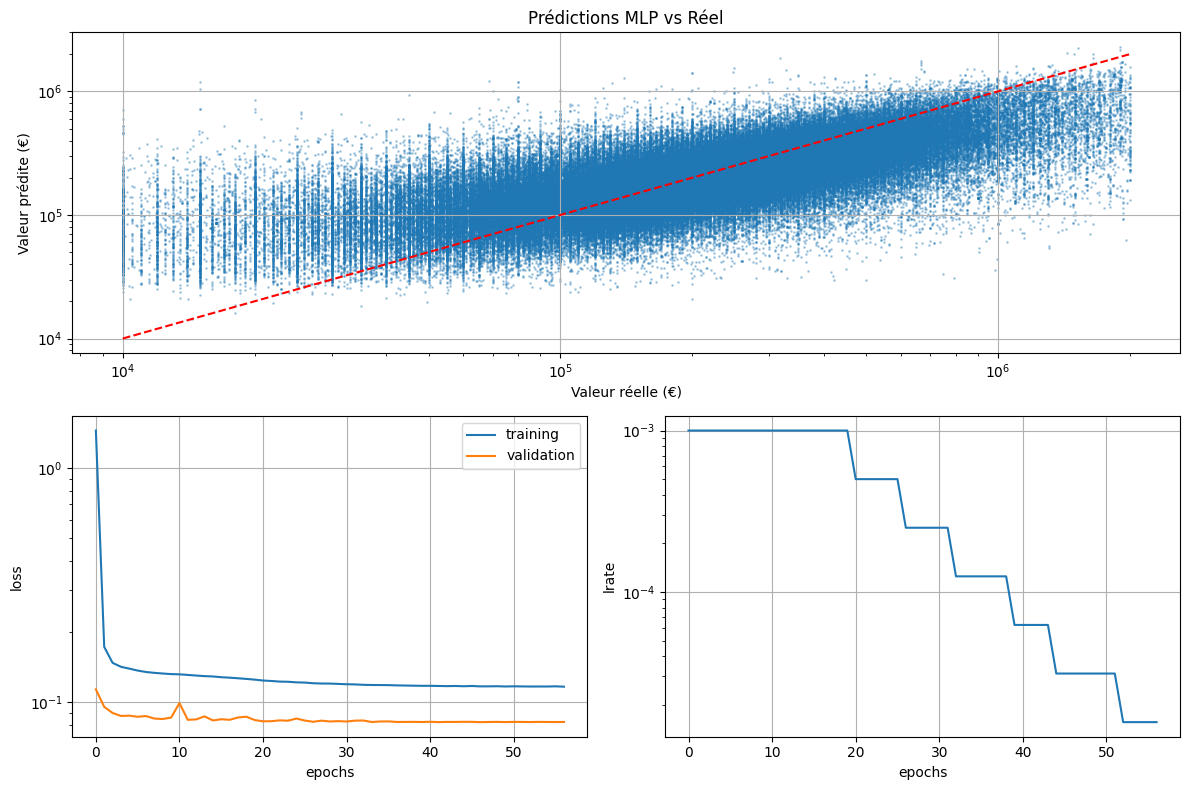

In [17]:
show_nn_stats(dataset_test, y_test, nn_model, history)

Après de nombreuses expérimentations sur des architectures de type MLP et resMLP, plusieurs observations claires émergent :

- **Meilleur modèle :** un **MLP shrinking à 3 couches de 512, 256, puis 1 neurone** (en sortie), avec une **fonction de coût Huber**, **batch size 4096**, et **early stopping + ReduceLROnPlateau**.  
  - **MAE : ~77 756 €**
  - **RMSE : ~118 625 €**
  - **R² : ~0.47** sur un échantillon de 500 000 données.

- Les modèles **resMLP** offrent une bonne régularisation mais **n’apportent pas de gain net** en performances par rapport aux MLP simples, avec des **R² plafonnant à ~0.44** malgré une meilleure stabilité.

Echantillon de 500 000 lignes :

| Architecture     | Layers | Neurons/couche | MAE (€)  | RMSE (€)  | R²      |
|------------------|--------|----------------|----------|-----------|---------|
| MLP (Shrinking)  | 3      | 512 -> 256 -> 1  | **77 756** | **118 625** | **0.47** |
| MLP (Shrinking)  | 3      | 256 -> 128 -> 1  | ~91 400  | ~165 800  | ~0.42   |
| MLP (Constant)   | 6      | 512            | ~90 700  | ~166 400  | ~0.42   |
| resMLP           | 3      | 512            | ~89 900  | ~163 000  | ~0.44   |
| resMLP           | 4      | 128            | ~91 700  | ~167 700  | ~0.41   |

Sur toutes les données :
| Architecture     | Layers | Neurons/couche | MAE (€)  | RMSE (€)  | R²      |
|------------------|--------|----------------|----------|-----------|---------|
| MLP (Shrinking)  | 3      | 512 -> 256 -> 1  | **87 295** | **156 621** | **0.48** |


Un MLP shrinking avec 3 couches (512 -> 256 -> 1) est actuellement le **meilleur compromis entre précision, robustesse et efficacité** pour la prédiction de la valeur foncière sur ce jeu de données.



---

# Comparaison MLP vs Random Forest

Les tests sur les différentes architectures de **MLP** ont permis d’atteindre un **score R² maximal de ~0.48**, légèrement inférieur à celui obtenu avec la **Random Forest** (~0.60 sur le jeu complet).

- Malgré l'utilisation de techniques diverses (**Dropout, BatchNormalization, résidus, learning rate scheduler, etc.**), les performances des réseaux de neurones restent **inférieures à celles d’un modèle RF**.
- Les MLP semblent **moins robustes aux valeurs extrêmes**, et nécessitent **beaucoup plus de réglages** pour atteindre un optimum stable.
- L’architecture shrinking offre les meilleurs résultats, mais reste perfectible.

Afin d'améliorer les performances du modèle on pourrait:
- **Explorer d’autres architectures**,
  - **CatBoost/LightGBM (gradient boosting optimisé)**
  - **Wide & Deep models**
- Intégrer davantage de **feature engineering** pour les variables catégorielles.
- Tester d'autres **loss functions**.

---

# Combinaison MLP + Random Forest : (hybride)

Après avoir évalué séparément des modèles **Random Forest** (RF) et **MLP (Multi-Layer Perceptron)**, il apparaît que :
- la **RF obtient de meilleures performances globales** (R² jusqu’à 0.6),
- le **MLP n'a pas atteint les performances de la Random Forest**, mais reste intéressant car il modélise différemment les relations entre les variables.
- mais aucun modèle seul ne parvient à capturer toute la structure sous-jacente aux données foncières.

On veut donc tirer profit des deux modèles à travers une **approche hybride**, afin d’essayer d'**améliorer la précision des prédictions**.

On va essayer différentes approches combinant RF et MLP :
1. **Moyennage** :
    - La prédiction finale est la moyenne pondérée des prédictions RF et MLP.
    - Approche simple, on espère que les erreurs non corrélées entre RF et MLP se compensent.

2. **Résiduel** :
    - On entraîne d’abord un modèle RF, puis on utilise un MLP pour prédire **l’erreur résiduelle** (ie. `valeur réelle - prédiction RF`).
    - Cette approche permet au MLP de ce **concentrer sur ce que la RF ne capture pas**.

3. **Enrichissement** :
    - On entraîne une RF, puis **on ajoute sa prédiction comme nouvelle variable d’entrée** pour le MLP. Le réseau de neurones utilise donc à la fois les données originales et la prédiction RF comme contexte pour améliorer ses estimations.


### Attentes :
- Une **amélioration du R²**, en réduisant les erreurs des prédictions RF/MLP prises isolément.
- Une **meilleure robustesse aux outliers** (effet "lissant" de l'average).
- Une **meilleure généralisation** si les erreurs des deux modèles ne sont pas fortement corrélées.

## MLP + RF (Moyennage )

In [272]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= False,
    sample_size= 5e5,
    log= True,
)

In [ ]:
y_pred_rf = rf.predict(X_test)
y_pred_mlp = nn_model.predict(dataset_test).flatten()

y_pred_rf_real = np.expm1(y_pred_rf)
y_pred_mlp_real = np.expm1(y_pred_mlp)
y_test_real = np.expm1(y_test)


beta = .9
y_pred_average = (beta * y_pred_rf_real) + ((1 - beta) * y_pred_mlp_real)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


MAE : 74100.50 €
RMSE : 130296.48 €
R² : 0.6410


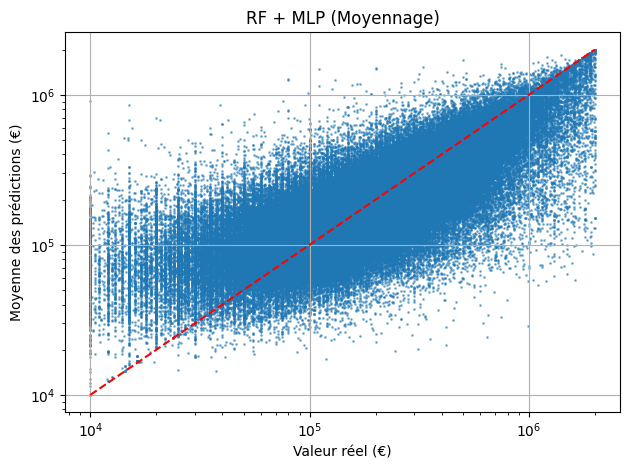

In [39]:
mae = mean_absolute_error(y_test_real, y_pred_average)
rmse = root_mean_squared_error(y_test_real, y_pred_average)
r2 = r2_score(y_test_real, y_pred_average)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure()
plt.scatter(y_test_real, y_pred_average, s= 1, alpha= .5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel("Valeur réel (€)")
plt.ylabel("Moyenne des prédictions (€)")
plt.title("RF + MLP (Moyennage)")
plt.grid(True)
plt.loglog()
plt.tight_layout()
plt.show()

### Résultats :

Après avoir testé différentes combinaisons de moyennes entre les prédictions du modèle Random Forest (RF) et celles du MLP, il apparaît clairement que **une pondération plus forte en faveur du modèle RF améliore significativement les performances globales**.

- Pour un **mélange équivalent 50%-50%**, les performances sont relativement dégradées :  
  - **MAE** : 112 441 €  
  - **RMSE** : 181 701 €  
  - **R²** : 0.31

- En revanche, avec une pondération **RF à 90% et MLP à 10%**, les résultats sont bien meilleurs :
  - **MAE** : 80 283 €  
  - **RMSE** : 143 377 €  
  - **R²** : 0.571

Ces observations montrent que, bien que le MLP seul n'atteigne pas les performances d'une Random Forest, **sa contribution peut permettre de légèrement corriger** les erreurs du modèle RF.

## MLP + RF (Résidus)

In [259]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= True,
    sample_size= 5e5,
    log= True,
)

In [40]:
y_rf_train = rf.predict(X_train)
y_rf_test = rf.predict(X_test)
y_residual = y_train - y_rf_train

residual_model = build_mlp_model(
    input_shape= X_train.shape[1],
    n_layers= 3,
    layer_size= 512,
    lrate= 1e-3,
    loss_function= "huber",
    layer_type= "shrinking"
)

residual_model.fit(
    X_train, y_residual,
    validation_split= .2,
    batch_size= 4096,
    epochs= epochs,
    callbacks= [early_stop, lr_scheduler],
    verbose= 1
)


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,369 (728.00 KB)

 Trainable params: 185,857 (726.00 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/200
190/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1254 - mae: 0.5453

2025-05-01 20:50:37.931554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_987', 180 bytes spill stores, 180 bytes spill loads

2025-05-01 20:50:37.976279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_175', 2904 bytes spill stores, 2876 bytes spill loads

2025-05-01 20:50:38.023266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_175', 488 bytes spill stores, 488 bytes spill loads

2025-05-01 20:50:38.062927: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_175_0', 1148 bytes spill stores, 1872 bytes spill loads

2025-05-01 20:50:38.072884: I 

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1207 - mae: 0.5286

2025-05-01 20:50:42.112429: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 128 bytes spill stores, 128 bytes spill loads

2025-05-01 20:50:42.190041: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 488 bytes spill stores, 488 bytes spill loads

2025-05-01 20:50:42.371664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 2904 bytes spill stores, 2876 bytes spill loads

2025-05-01 20:50:42.400815: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43_0', 1148 bytes spill stores, 1872 bytes spill loads

2025-05-01 20:50:42.410684: I exte

211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.1205 - mae: 0.5278 - val_loss: 0.0396 - val_mae: 0.2289 - learning_rate: 0.0010
Epoch 2/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0394 - mae: 0.2293 - val_loss: 0.0393 - val_mae: 0.2280 - learning_rate: 0.0010
Epoch 3/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0386 - mae: 0.2255 - val_loss: 0.0389 - val_mae: 0.2263 - learning_rate: 0.0010
Epoch 4/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0385 - mae: 0.2249 - val_loss: 0.0388 - val_mae: 0.2262 - learning_rate: 0.0010
Epoch 5/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0384 - mae: 0.2245 - val_loss: 0.0387 - val_mae: 0.2254 - learning_rate: 0.0010
Epoch 6/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0382 - mae: 0.2239 - val_loss: 0.0387 - val_mae: 0.2256 - learning_rate: 0.0010
Epoch 7/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0384 - mae: 0.2246 - val_loss: 0.0387 - val_mae: 0.2252 - learning_rate: 0.0010
Epoch 8/20

2025-05-01 20:51:26.570538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35_0', 44 bytes spill stores, 44 bytes spill loads

2025-05-01 20:51:26.661100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 484 bytes spill stores, 484 bytes spill loads



10505/10512 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-05-01 20:52:03.723409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35_0', 36 bytes spill stores, 36 bytes spill loads

2025-05-01 20:52:03.980575: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 488 bytes spill stores, 488 bytes spill loads



10512/10512 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
MAE: 72944.85100172293
RMSE: 128588.4493384089
R²: 0.6503720474368517


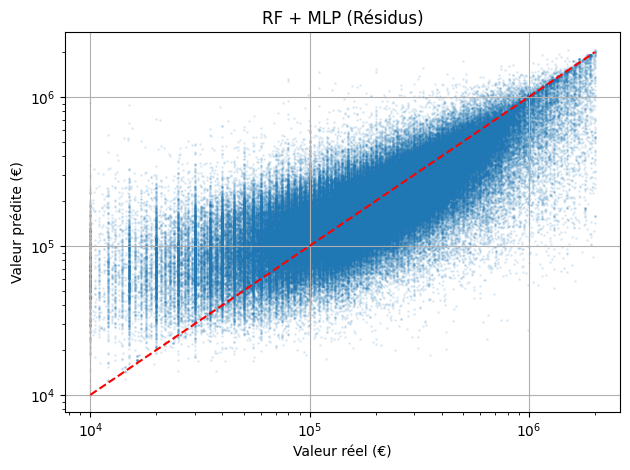

In [41]:
residual_correction = residual_model.predict(X_test).flatten()

y_pred_combined = y_rf_test + residual_correction

y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_combined)

print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", root_mean_squared_error(y_true, y_pred))
print("R²:", r2_score(y_true, y_pred))

plt.figure()
plt.scatter(y_test_real, y_pred, s= 1, alpha= .1)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel("Valeur réel (€)")
plt.ylabel("Valeur prédite (€)")
plt.title("RF + MLP (Résidus)")
plt.grid(True)
plt.loglog()
plt.tight_layout()
plt.show()

### Résultats :

Dans cette approche, le modèle Random Forest est d'abord utilisé pour effectuer une prédiction initiale. Ensuite on entraine un MLP sur le résidu avec la valeur cible.

La prédiction finale est obtenue en **ajoutant la sortie du MLP à celle de la RF**.

On utilise le modèle que l'on a déterminé comme le plus performant précédement :
- MLP à **3 couches** en configuration "shrinking" (`512 -> 256 -> 1`)

### Résultats obtenus avec un échantillon de 500 000 lignes :
- **MAE** : 76 777 €
- **RMSE** : 139 199 €
- **R²** : 0.594

### Conclusion :
Cette méthode surpasse à la fois :
- la moyenne simple (même pondérée),
- et les modèles MLP ou RF seuls.

Elle montre donc un que l'hybridation éxploite les points forts des deux modèles :
- RF : robuste, non paramétrique, bon sur des données bruyantes,
- MLP : capable de capturer des régularités fines dans les erreurs.

C’est **l’approche la plus performante** testée jusqu’ici. Une combinaison avec d'autres techniques (feature engineering résiduel) pourrait encore améliorer les performances.

## RF + MLP (Enrichissement)

Dans cette dernière approche, nous allons enrichir nos données, c'est à dire utiliser les prédictions d’un premier modèle comme **feature** d'entrée pour un second modèle.

Contrairement à une simple moyenne ou une modélisation de résidu, ici :
- Le modèle **Random Forest** est entraîné en premier pour produire une prédiction brute.
- Cette prédiction est **ajoutée aux variables originales** comme une **nouvelle feature d'entrée**.
- Un **MLP** est ensuite entraîné sur cet ensemble enrichi, avec l’objectif de produire la prédiction finale.

Contrairement à la moyenne ou au résidu, le MLP peut combiner non-linéairement toutes les variables avec la sortie de la RF.

Cela permet aussi au second modèle de **corriger les erreurs** du premier.

Nous espérons que cette méthode permettra :
- d’**améliorer le score R²** au-delà de ce que l’on obtient avec un modèle unique ou un modèle hybride,
- de **réduire davantage les erreurs**, en capturant les cas où la RF se trompe,

Les tests seront réalisés avec un MLP similaire à ceux utilisés précédemment.

In [156]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= True,
    sample_size= 5e5,
    log= True,
)

In [42]:
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

In [43]:
X_train_enriched = np.hstack([X_train.toarray(), y_rf_train.reshape(-1, 1)])
X_test_enriched = np.hstack([X_test.toarray(), y_rf_test.reshape(-1, 1)])

In [44]:
mlp = build_mlp_model(
    input_shape= X_train_enriched.shape[1],
    n_layers= 3,
    layer_size= 512,
    lrate= 1e-3,
    loss_function= "huber",
    layer_type= "shrinking"
)

mlp.fit(
    X_train_enriched, y_train,
    validation_split= .2,
    batch_size= 4096,
    epochs= epochs,
    callbacks= [early_stop, lr_scheduler],
    verbose= 0
)

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        54,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,881 (730.00 KB)

 Trainable params: 186,369 (728.00 KB)

 Non-trainable params: 512 (2.00 KB)

10512/10512 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
MAE: 75313.4029941939
RMSE: 131265.9539325865
R²: 0.6356603584959128


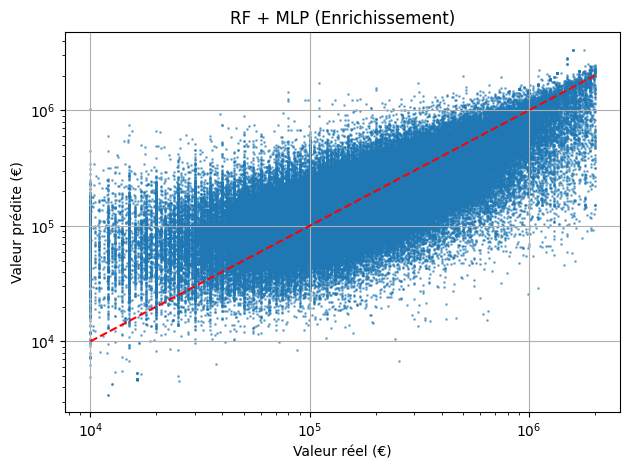

In [45]:
y_pred_mlp = mlp.predict(X_test_enriched).flatten()
y_test_real = np.expm1(y_test)
y_pred = np.expm1(y_pred_mlp)

print("MAE:", mean_absolute_error(y_test_real, y_pred))
print("RMSE:", root_mean_squared_error(y_test_real, y_pred))
print("R²:", r2_score(y_test_real, y_pred))

plt.figure()
plt.scatter(y_test_real, y_pred, s= 1, alpha= .5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel("Valeur réel (€)")
plt.ylabel("Valeur prédite (€)")
plt.title("RF + MLP (Enrichissement)")
plt.grid(True)
plt.loglog()
plt.tight_layout()
plt.show()

### Résultats

L'approche d'**enrichissement**, permet d’obtenir les performances suivantes sur le jeu de test (échantillon):

- **MAE** : 79 638 €
- **RMSE** : 145 771 €
- **R²** : 0.555

Bien que ce résultat ne surpasse pas le meilleur score obtenu via la méthode par résidu (R² = 0.59), il reste **significativement meilleur** que les résultats obtenus par les modèles MLP seuls ou le moyennage (R² = 0.31 à 0.48).

On constate que l'**enrichissement permet une combinaison plus souple** et potentiellement plus informative, car le MLP a la capacité de traiter la prédiction RF **comme une variable dépendante du contexte**, ce qui peut être plus efficace qu’un simple ajustement linéaire (comme dans le moyennage).


L'enrichissement semble être une **approche prometteuse**, en particulier lorsque les modèles de base sont **hétérogènes et complémentaires**, comme c’est le cas ici entre RF (modèle de forêt d’arbres décisionnels) et MLP (réseau neuronal dense).

Cette approche montre que **combiner des modèles** reste une voie robuste pour améliorer les performances de prédiction dans des contextes complexes comme ici.

---

# Conclusion Générale

Plusieurs approches de modélisation ont été explorées afin de prédire la **valeur foncière** à partir d’un grand volume de données issues des transactions immobilières (VDF) :

**Analyse Exploratoire et Prétraitement :**
- Un important travail de nettoyage, filtrage et normalisation a permis de structurer une base cohérente, représentative et exploitable de nos données.
- La **phase de clustering** n’a pas permis d’identifier des regroupements véritablement **cohérents ou exploitables**.
- Malgré des scores de silhouette modérés et une segmentation visuellement observable, les clusters obtenus ne présentaient pas de profils suffisamment distincts ou interprétables (petits appartements chers à Paris, grandes maisons bon marché en province).

**Réduction de Dimensionnalité (PCA) :**
- L’analyse en composantes principales (**PCA**) a permis de **réduire la dimensionnalité**, mais elle s’est révélée **contre-productive pour les modèles prédictifs**.
- En filtrant de la variance jugée non informative, la PCA a aussi supprimé des signaux utiles à la prédiction, conduisant à une baisse de performance (R² plus faible sur tous les modèles testés).

** Modélisation avec Random Forest :**
- La **Random Forest** a offert des résultats robustes (R² = 0.6) sur l’ensemble des données, surpassant les autres modèles testés.

**Réseaux de Neurones (MLP et ResMLP) :**
- Plusieurs architectures de MLP ont été testées (3 à 6 couches, constants ou shrinking), avec batch normalization, dropout, et régularisation adaptative.
- Malgré des efforts de tuning, les **MLP seuls** ont montré des performances légèrement inférieures aux RF (R² = 0.48 au maximum), mais avec un bon potentiel d’amélioration.

**Approches hybride :**
- Trois autres approches ont été testées :
  - **Moyennage (RF + MLP)** : combinaison pondérée, avec de bons résultats pour un fort poids donné à RF (R² = 0.57),
  - **Résidus** : le MLP prédit l’erreur résiduelle de RF ; meilleure performance obtenue (R² = 0.59),
  - **Enrichissement** : Prédictions RF puis agrégation du résultat avec les données original, enfin prédiction du MLP ; R² = 0.55.

Ces approches montrent que la **synergie entre modèles hétérogènes** permet de gagner en performance.

### Pistes d'Amélioration

Plusieurs axes peuvent être envisagés pour poursuivre ce travail :
- **Tuning plus fin** des hyperparamètres.
- Exploration de **nouvelles architectures neuronales**.
- Meilleure **gestion des valeurs extrêmes**, notamment pour réduire l’impact sur RMSE.
- Introduire des **features supplémentaires** (distance à un centre-ville, zonage fiscal ,démographie, économie locale, transports etc.).
- Créer des **modèles locaux** (par département ou zone géographique) pour capturer des dynamiques régionales spécifiques.
- Tester des **modèles plus récents et adaptés aux données tabulaires** : LightGBM, etc.

En résumé, **les modèles de type arbre (RF) restent les plus adaptés** dans ce contexte. Les réseaux neuronaux sont prometteurs mais **nécessitent des ajustements plus fins et des données très bien préparées** pour égaler les méthodes traditionnelles.